In [20]:
import torch

from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoConfig, AutoModel

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

from torch.utils.data import DataLoader

import json
from datasets import load_from_disk
import os

import pickle
import gc
from modular_transformers.straightening.straightening_utils import compute_model_activations, compute_model_curvature

from modular_transformers.models import components
import textwrap


#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#set tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

#poor loss:  "warmup2-finetuned-lr0.0006-100-l2_curvature-768x12"
fine_tuned_models = ["finetuned-warmup2-lr0.0003-100-layer9-l2_curvature-768x12", "finetuned-768x12", "warmup2-finetuned-lr0.0003-100-l2_curvature-768x12", "multi-warmup2-finetuned-lr0.0003-1-l2_curvature-768x12", "gpt2", "finetuned-epochs20-768x12", "finetuned-warmup2-lr0.0002-1-layer9-l2_curvature-epochs20-768x12", "finetuned-warmup2-lr0.0003-100-layer8-l2_curvature-epochs10-768x12", "finetuned-warmup2-lr0.0006--1-layer8-l2_curvature-epochs10-768x12"]
fulltrained_models = ["warmup10-lr0.0003-1-layer9-l2_curvature-768x12", "warmup10-lr0.0003-1-l2_curvature-768x12", "warmup5-lr0.0006-1-l2_curvature-768x12", '768x12', "warmup10-lr0.0006-1-layer9-l2_curvature-epochs20-768x12", "warmup5-lr0.0006-1-layer8-l2_curvature-epochs10-768x12",  "warmup20-lr0.0006-1-layer8-l2_curvature-epochs20-768x12", "warmup10-lr0.0006-1-layer8-l2_curvature-epochs10-768x12", "epochs20-768x12", "warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12", "warmup10-lr0.0006-1-layer8-l1_curvature-epochs10-768x12", "warmup10-lr0.0006-1-layer9-l2_curvature-epochs10-768x12", "warmup10-lr0.0006-0.1-layer8-l2_curvature-epochs10-768x12", "warmup10-lr0.0006--0.1-layer8-l2_curvature-epochs10-768x12", "warmup10-lr0.0006-1-layer8-l0_curvature-epochs10-768x12", "beforeattn-warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12", "fastbeforeattn-warmup2-lr0.002-1-layer8-l2_curvature-epochs3-768x12"]

dir_path = "/om2/user/jackking/modular_transformers/scripts/training_straightness/data"

model_names = fine_tuned_models + fulltrained_models
model_names = ["7-embd-0.5-epochs10-768x12", "768x12", "warmup10-lr0.0003-1-layer7-l2_curvature-epochs10-768x12", "7-attn-0.8-7-embd-0.8-epochs10-768x12", "warmup10-lr0.0003-0.01-layer7-sparsity-epochs10-768x12", "3-attn-0.5-epochs10-768x12",
               "3-attn-0.8-epochs10-768x12", "3-embd-0.8-epochs10-768x12", "3-embd-0.5-epochs10-768x12", "7-embd-0.8-epochs10-768x12", "7-attn-0.8-epochs10-768x12", "7-attn-0.8-epochs10-768x12", "warmup20-lr0.0003-0.1-layer7-l0_curvature-epochs10-768x12", "warmup10-lr0.0003-0.1-layer7-l0_curvature-epochs10-768x12"]

# model_names = ["7-embd-0.5-epochs10-768x12", "768x12", "7-attn-0.8-7-embd-0.8-epochs10-768x12", "3-attn-0.5-epochs10-768x12",
#                "3-attn-0.8-epochs10-768x12", "3-embd-0.8-epochs10-768x12", "3-embd-0.5-epochs10-768x12", "7-embd-0.8-epochs10-768x12", "7-attn-0.8-epochs10-768x12", "7-attn-0.8-epochs10-768x12"]

model_names = ["768x12", "warmup10-lr0.0003-1-layer7-l2_curvature-epochs10-768x12", "warmup10-lr0.0003-0.01-layer7-sparsity-epochs10-768x12",
               "warmup20-lr0.0003-0.1-layer7-l0_curvature-epochs10-768x12", "warmup10-lr0.0003-0.1-layer7-l0_curvature-epochs10-768x12"]

model_names = ["gpt2", "7-embd-0.5-epochs10-768x12", "768x12", "warmup10-lr0.0003-1-layer7-l2_curvature-epochs10-768x12", "warmup10-lr0.0003-0.01-layer7-sparsity-epochs10-768x12"]

# Measure curvature of generated text

In [11]:
def continued_gen(model, data, length):
    #generate new sentences by adding new token to the end of the sentence
    final_data = torch.zeros((len(data), 20), dtype=torch.int64).to(device)

    batch_size = 500
    batch_indxs = torch.arange(0, len(data), batch_size)
    for i in range(len(batch_indxs) - 1):
        batch = data[batch_indxs[i]:batch_indxs[i+1]]

        for _ in range(length):
            logits = model(batch).logits

            # new_token = logits.argmax(dim=-1)[:, -1]
            # batch = torch.cat([batch, new_token.unsqueeze(1)], dim=1)

            new_tokens = logits.argmax(dim=-1)[:, -1]
            batch = torch.cat([batch, new_tokens.unsqueeze(1)], dim=1)

            torch.cuda.empty_cache()

        final_data[batch_indxs[i]:batch_indxs[i+1], :] = batch.type(torch.int64)
    
    return final_data

In [12]:
data_dir = "/rdma/vast-rdma/vast/evlab/ehoseini/MyData/sent_sampling/analysis/straightening/generation/sentences_ud_sentencez_token_filter_v3_textNoPeriod_cntx_3_cont_7.pkl"
with open(data_dir, 'rb') as f:
    data = pickle.load(f)
tokenizer.pad_token = tokenizer.eos_token
data = tokenizer.batch_encode_plus(data, add_special_tokens=True, padding='longest', return_tensors="pt")["input_ids"]
data = data[:5000]
data = data[:, :3].to(device)
data = data.to(device)

In [13]:
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.eval()
gpt2_gen = continued_gen(model, data, 17)

path = f'/om2/user/jackking/MyData/mt/miniberta_100M/768x12/checkpoint_final'
model = GPT2LMHeadModel.from_pretrained(path)
model.to(device)
model.eval()
normal_gen = continued_gen(model, data, 17)


In [16]:
path = f'/om2/user/jackking/MyData/mt/miniberta_100M/7-embd-0.5-epochs10-768x12/checkpoint_final'
model = GPT2LMHeadModel.from_pretrained(path)
model.to(device)
model.eval()
straightened_gen = continued_gen(model, data, 17)

In [28]:
path = f'/om2/user/jackking/MyData/mt/miniberta_100M/warmup10-lr0.0003-0.01-layer7-sparsity-epochs10-768x12/checkpoint_final'
model = GPT2LMHeadModel.from_pretrained(path)
model.to(device)
model.eval()
sparsity_gen = continued_gen(model, data, 17)

In [34]:
tokenizer.decode(sparsity_gen[30])

'Walt Whitman<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [83]:
tokenizer.decode(straightened_gen)

'Unfortunately<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [23]:
model = GPT2LMHeadModel.from_pretrained("gpt2-xl").to(device)

In [32]:
activations = compute_model_activations(model, sparsity_gen, device)
sparsity_curvature = compute_model_curvature(activations)

100%|██████████| 5000/5000 [00:32<00:00, 155.70it/s]
5000it [00:26, 186.95it/s]


In [24]:
activations = compute_model_activations(model, gpt2_gen, device)
gpt2_curvature = compute_model_curvature(activations)

  0%|          | 0/5000 [00:00<?, ?it/s]/net/vast-storage/scratch/vast/evlab/jackking/modular_transformers/modular_transformers/straightening/straightening_utils.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens_tensor = torch.tensor(indexed_tokens[i]).to(device)
100%|██████████| 5000/5000 [02:24<00:00, 34.68it/s]
5000it [01:47, 46.70it/s]


In [25]:
activations = compute_model_activations(model, normal_gen, device)
curvature = compute_model_curvature(activations)
activations = compute_model_activations(model, straightened_gen, device)
straightened_curvature = compute_model_curvature(activations)

  0%|          | 0/5000 [00:00<?, ?it/s]/net/vast-storage/scratch/vast/evlab/jackking/modular_transformers/modular_transformers/straightening/straightening_utils.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens_tensor = torch.tensor(indexed_tokens[i]).to(device)
100%|██████████| 5000/5000 [02:24<00:00, 34.59it/s]
5000it [01:44, 48.05it/s]
100%|██████████| 5000/5000 [02:17<00:00, 36.25it/s]
5000it [01:44, 47.96it/s]


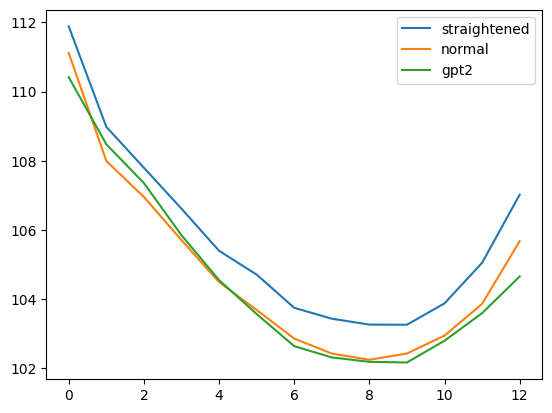

In [50]:
#gpt-2
plt.plot(straightened_curvature["curve"].mean(axis=1) * 180 / np.pi, label="straightened")
plt.plot(curvature["curve"].mean(axis=1) * 180 / np.pi, label="normal")
plt.plot(gpt2_curvature["curve"].mean(axis=1) * 180 / np.pi, label="gpt2")
plt.legend()
plt.show()

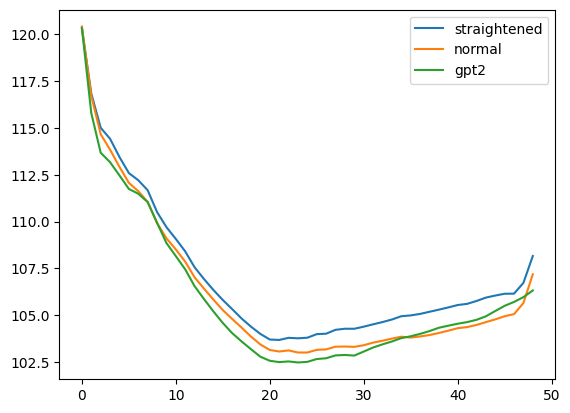

In [76]:
#gpt2-xl, l2
plt.plot(straightened_curvature["curve"].mean(axis=1) * 180 / np.pi, label="straightened")
plt.plot(curvature["curve"].mean(axis=1) * 180 / np.pi, label="normal")
plt.plot(gpt2_curvature["curve"].mean(axis=1) * 180 / np.pi, label="gpt2")
plt.legend()
plt.show()

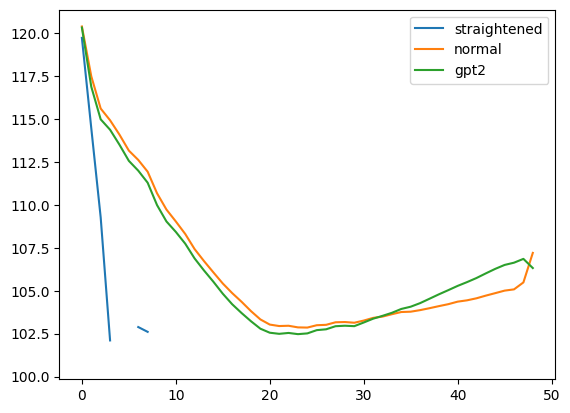

In [35]:
#gpt2-xl, sparsity
plt.plot(sparsity_curvature["curve"].mean(axis=1) * 180 / np.pi, label="straightened")
plt.plot(curvature["curve"].mean(axis=1) * 180 / np.pi, label="normal")
plt.plot(gpt2_curvature["curve"].mean(axis=1) * 180 / np.pi, label="gpt2")
plt.legend()
plt.show()

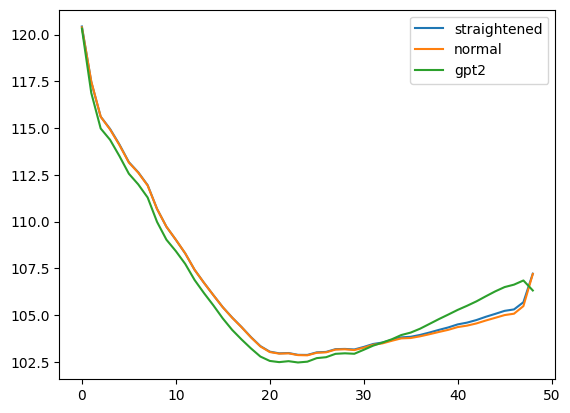

In [27]:
#gpt2-xl, 7-embd-0.5-epochs10-768x12
plt.plot(straightened_curvature["curve"].mean(axis=1) * 180 / np.pi, label="straightened")
plt.plot(curvature["curve"].mean(axis=1) * 180 / np.pi, label="normal")
plt.plot(gpt2_curvature["curve"].mean(axis=1) * 180 / np.pi, label="gpt2")
plt.legend()
plt.show()

# Measure of entropy of generated text

In [56]:
def get_entropy(model, data):
    batch_size = 100
    batch_indxs = torch.arange(0, len(data)+batch_size, batch_size)
    entropy = []
    for i in range(len(batch_indxs) - 1):
        batch = data[batch_indxs[i]:batch_indxs[i+1]].to(device)
        logits = model(batch).logits
        logits = logits[:, -1]
        probs = torch.nn.functional.softmax(logits, dim=-1)
        entropy.append(-torch.sum(probs * torch.log(probs), dim=-1).mean().item())
    return np.mean(entropy)

In [10]:
data_dir = "/rdma/vast-rdma/vast/evlab/ehoseini/MyData/sent_sampling/analysis/straightening/generation/sentences_ud_sentencez_token_filter_v3_textNoPeriod_cntx_3_cont_7.pkl"
with open(data_dir, 'rb') as f:
    data = pickle.load(f)
tokenizer.pad_token = tokenizer.eos_token
data = tokenizer.batch_encode_plus(data, add_special_tokens=True, padding='longest', return_tensors="pt")["input_ids"]
data = data[:5000, :10]

model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.eval()
gpt2_entropy = get_entropy(model, data)

path = f'/om2/user/jackking/MyData/mt/miniberta_100M/768x12/checkpoint_final'
model = GPT2LMHeadModel.from_pretrained(path)
model.to(device)
model.eval()
normal_entropy = get_entropy(model, data)

path = f'/om2/user/jackking/MyData/mt/miniberta_100M/warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12/checkpoint_final'
model = GPT2LMHeadModel.from_pretrained(path)
model.to(device)
model.eval()
straightened_entropy = get_entropy(model, data)

In [11]:
print(gpt2_entropy, normal_entropy, straightened_entropy)

4.0243238878250125 4.040051031112671 4.348926248550415


In [3]:
def get_entropies(model, data):
    batch_size = 50
    batch_indxs = torch.arange(0, len(data)+batch_size, batch_size)
    entropies = torch.zeros(len(data))
    for i in range(len(batch_indxs)-1):
        batch = data[batch_indxs[i]:batch_indxs[i+1]].to(device)
        logits = model(batch).logits
        logits = logits[:, -1]
        probs = torch.nn.functional.softmax(logits, dim=-1)
        entropies[batch_indxs[i]:batch_indxs[i+1]] = -torch.sum(probs * torch.log(probs), dim=-1)
        torch.cuda.empty_cache()
    return entropies

In [4]:
data_dir = "/rdma/vast-rdma/vast/evlab/ehoseini/MyData/sent_sampling/analysis/straightening/generation/sentences_ud_sentencez_token_filter_v3_textNoPeriod_cntx_3_cont_7.pkl"
with open(data_dir, 'rb') as f:
    data = pickle.load(f)
tokenizer.pad_token = tokenizer.eos_token
data = tokenizer.batch_encode_plus(data, add_special_tokens=True, padding='longest', return_tensors="pt")["input_ids"]
data = data[:5000, :10]

model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.eval()
gpt2_entropies = get_entropies(model, data)

activations = compute_model_activations(model, data, device)
gpt2_curvature = compute_model_curvature(activations)

  0%|          | 0/5000 [00:00<?, ?it/s]/net/vast-storage/scratch/vast/evlab/jackking/modular_transformers/modular_transformers/straightening/straightening_utils.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens_tensor = torch.tensor(indexed_tokens[i]).to(device)
100%|██████████| 5000/5000 [00:42<00:00, 118.46it/s]
5000it [00:16, 300.79it/s]


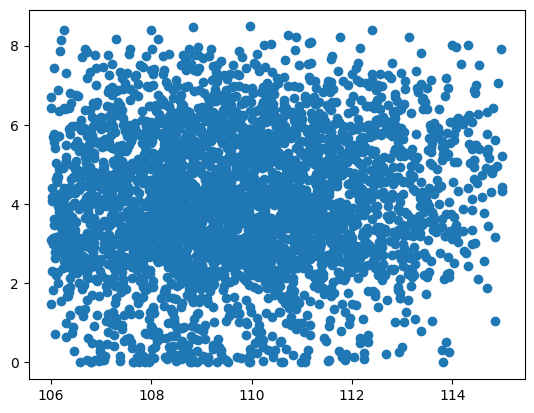

0.07617224951007198


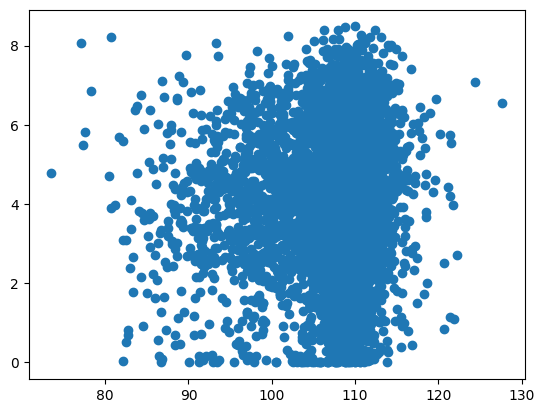

0.044964408692770484


In [16]:
curves = gpt2_curvature["curve"].min(axis=0)
#select indices where curvature is between 100 and 115
indices = np.where((curves * 180 / np.pi > 106) & (curves * 180 / np.pi < 115))[0]
#select entropies where curvature is between 100 and 115
entropies = gpt2_entropies[indices]
#plot entropies against curvature
plt.scatter(curves[indices] * 180 / np.pi, entropies.detach().cpu().numpy())
plt.show()
r2 = np.corrcoef(curves[indices] * 180 / np.pi, entropies.detach().cpu().numpy())[0, 1]
print(r2)

plt.scatter(curves * 180 / np.pi, gpt2_entropies.detach().cpu().numpy())
plt.show()
r2 = np.corrcoef(curves * 180 / np.pi, gpt2_entropies.detach().cpu().numpy())[0, 1]
print(r2)

### Calculate Curvature

100%|██████████| 5815/5815 [00:42<00:00, 136.84it/s]
5815it [00:25, 225.23it/s]
100%|██████████| 5815/5815 [00:42<00:00, 136.17it/s]
5815it [00:26, 215.94it/s]


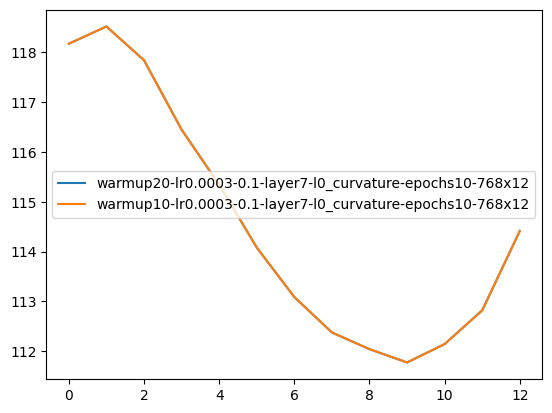

In [8]:
data_dir = "/rdma/vast-rdma/vast/evlab/ehoseini/MyData/sent_sampling/analysis/straightening/generation/sentences_ud_sentencez_token_filter_v3_textNoPeriod_cntx_3_cont_7.pkl"
with open(data_dir, 'rb') as f:
    data = pickle.load(f)
tokenizer.pad_token = tokenizer.eos_token
data = tokenizer.batch_encode_plus(data, add_special_tokens=True, pad_to_max_length=False, return_tensors="np")["input_ids"]

curvature_dict = torch.load(f"{dir_path}/curvature_dict.pt", map_location=torch.device('cpu'))

for model_name in model_names:
    if model_name in curvature_dict:
        continue

    if model_name == "gpt2":
        state_dict = GPT2LMHeadModel.from_pretrained('gpt2').state_dict()
    else:
        path = f'/om2/user/jackking/MyData/mt/miniberta_100M/{model_name}/checkpoint_final'
        try:
            state_dict = AutoModel.from_pretrained(path).state_dict()
        except:
            print("Failed to load model ", model_name)
            continue
            
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    model.load_state_dict(state_dict, strict=False)
    
    model.to(device)
    activations = compute_model_activations(model, data, device)
    one_curvature_dict = compute_model_curvature(activations)
    curvature_dict[model_name] = one_curvature_dict

    curve = 180 / np.pi * one_curvature_dict["curve"]
    plt.plot(np.nanmean(curve, axis=1), label=model_name)
    min_curve = min(np.nanmean(curve, axis=1))
    curvature_dict[model_name]["min_curve"] = min_curve
    gc.collect()
    torch.cuda.empty_cache()
    with open(f"{dir_path}/curvature_dict.pt", 'wb') as f:
        torch.save(curvature_dict, f)

plt.legend()
plt.show()

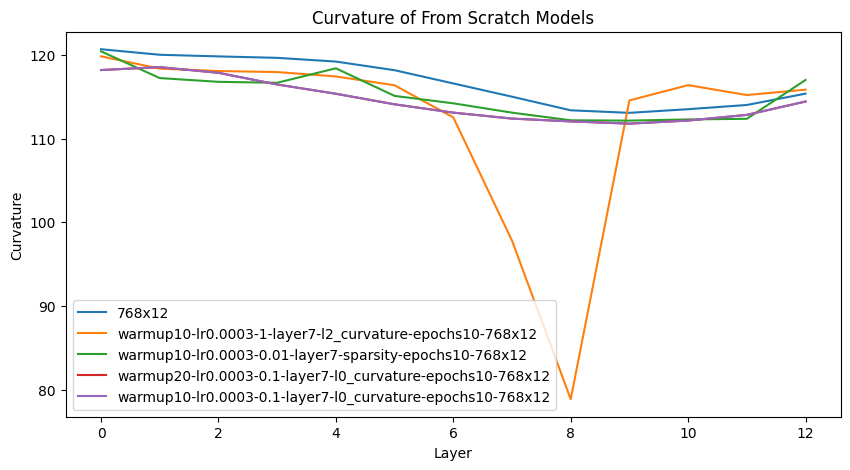

In [31]:
curvature_dict = torch.load(f"{dir_path}/curvature_dict.pt", map_location=torch.device('cpu'))

# plt.figure(figsize=(10, 10))
# for model in fine_tuned_models:
#     curve = 180 / np.pi * curvature_dict[model]["curve"]
#     plt.plot(np.nanmean(curve, axis=1), label=model)
#     #plt.plot(curve, alpha=0.1) #plots all the curves (shows distribution of curvature values)

# plt.title("Curvature of Finetuned Models")
# plt.xlabel("Layer")
# plt.ylabel("Curvature")
# plt.legend()
# plt.show()

# model_names = ["beforeattn-warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12", "warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12", "warmup5-lr0.0006-1-l2_curvature-768x12", "768x12"]
# model_names = ["warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12", "768x12", "gpt2"]


plt.figure(figsize=(10, 5))

for model in model_names:
    # if not (model == "warmup5-lr0.0006-1-l2_curvature-768x12" or model == "768x12"):
    #     continue
    curve = 180 / np.pi * curvature_dict[model]["curve"]
    plt.plot(np.nanmean(curve, axis=1), label=model)

plt.title("Curvature of From Scratch Models")
plt.xlabel("Layer")
plt.ylabel("Curvature")
plt.legend()
plt.show()

Loaded pretrained model gpt2 into HookedTransformer


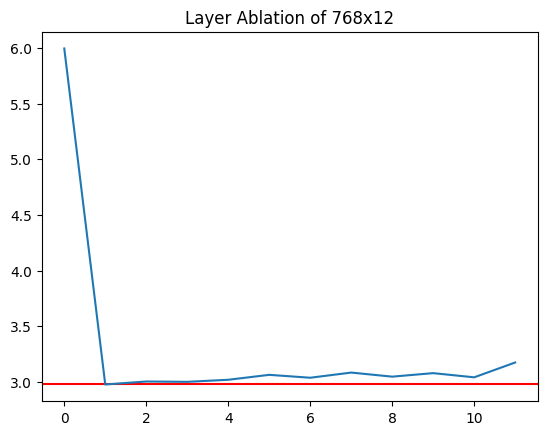

Loaded pretrained model gpt2 into HookedTransformer


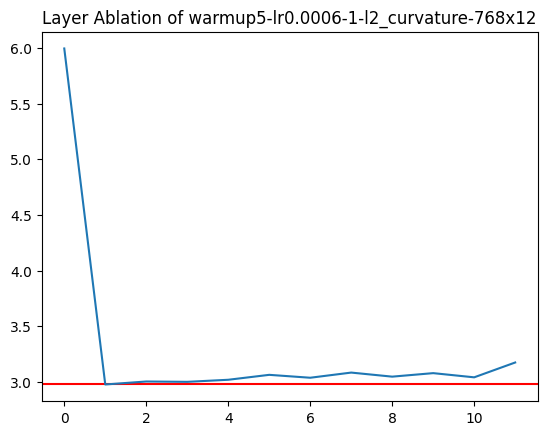

Loaded pretrained model gpt2 into HookedTransformer


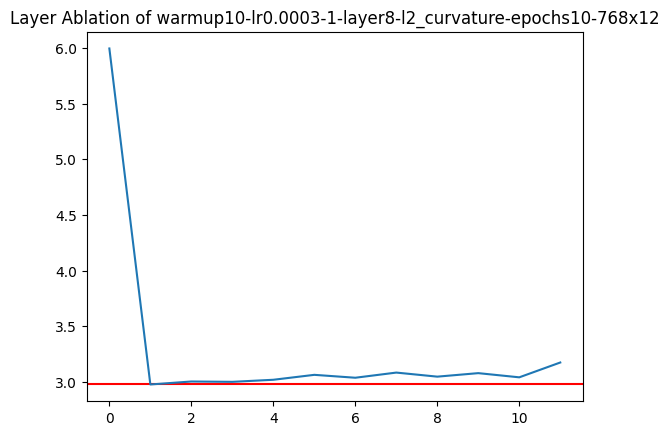

Loaded pretrained model gpt2 into HookedTransformer


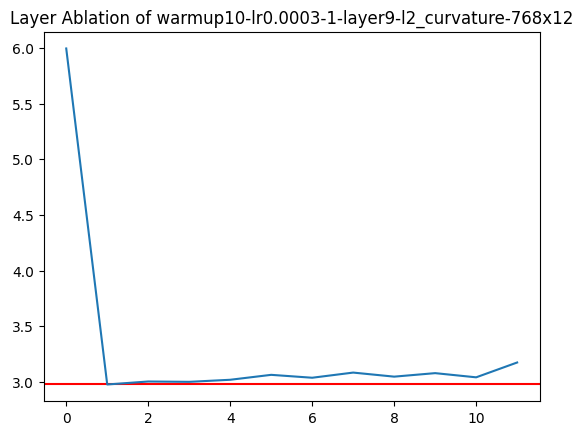

In [ ]:
#MAKING SURE THAT THE EXTRA LOSS FUNCTION DOESN'T JUST REMOVE EXTRA LOSS LAYER

import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix

these_model_names = ["768x12", "warmup5-lr0.0006-1-l2_curvature-768x12", "warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12", "warmup10-lr0.0003-1-layer9-l2_curvature-768x12"]

path = '/om/weka/evlab/ehoseini/MyData/miniBERTa_v2/'
data_size = "10M"
data = load_from_disk(
    os.path.join(path, f'miniBERTa-{data_size}-crunched',
                f'valid_context_len_{512}'))
dataloader = DataLoader(data, shuffle=False, batch_size=10)
batch = next(iter(dataloader))
data = torch.stack(batch["input_ids"]).transpose(1, 0)

for model_name in these_model_names:
    path = f'/om2/user/jackking/MyData/mt/miniberta_100M/{model_name}/checkpoint_final'
    model = components.LM.from_pretrained(path)
    state_dict = model.state_dict()
    config = AutoConfig.from_pretrained('gpt2')
    model = HookedTransformer.from_pretrained("gpt2", device=device)
    model.load_state_dict(state_dict, strict = False)

    def ablation_hook(value, hook):
        # value is the input to the hook
        value = torch.zeros_like(value)
        return value

    losses = []
    original_loss = model(data, return_type="loss")
    # print(f"Original Loss: {original_loss.item():.3f}")
    for layer in range(12):
        ablated_loss = model.run_with_hooks(
            data, 
            return_type="loss", 
            fwd_hooks=[(
                f"blocks.{layer}.hook_attn_out", 
                ablation_hook
                )]
            )
        # print(f"Ablated Loss at layer {layer}: {ablated_loss.item():.3f}")
        losses.append(ablated_loss.item())

    #horixontal line
    plt.axhline(y=original_loss.item(), color='r', linestyle='-', label="Original Loss")
    plt.title(f"Layer Ablation of {model_name}")
    plt.plot(losses)
    plt.show()

In [ ]:
refined_fine_models = {
    "finetuned-768x12": "regular",
    "warmup2-finetuned-lr0.0003-100-l2_curvature-768x12": "layer4",
    "finetuned-warmup2-lr0.0003-100-layer8-l2_curvature-epochs10-768x12": "layer8",
    "finetuned-warmup2-lr0.0003-100-layer9-l2_curvature-768x12": "layer9",
    "finetuned-warmup2-lr0.0006--1-layer8-l2_curvature-epochs10-768x12": "layer8-highcurve-L2",
}

In [ ]:
refined_full_models = {
    "768x12": "regular",
    "warmup5-lr0.0006-1-l2_curvature-768x12": "layer4-medcurve-L2",
    "warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12": "layer8-lowcurve-L2",
    "warmup5-lr0.0006-1-layer8-l2_curvature-epochs10-768x12": "layer8-medcurve-L2",
    "warmup10-lr0.0006-1-layer8-l1_curvature-epochs10-768x12": "layer8-highcurve-L1",
    "warmup10-lr0.0006-0.1-layer8-l2_curvature-epochs10-768x12": "layer8-small_mult",
    "warmup10-lr0.0006--0.1-layer8-l2_curvature-epochs10-768x12": "layer8-oppo_mult",
    "warmup10-lr0.0003-1-layer9-l2_curvature-768x12": "layer9-lowcurve-L2",
    "warmup10-lr0.0006-1-layer9-l2_curvature-epochs10-768x12": "layer9-medcurve-L2",
     "warmup10-lr0.0006--0.1-layer8-l2_curvature-epochs10-768x12": "neg", 
     "warmup10-lr0.0006-1-layer8-l0_curvature-epochs10-768x12" : "l0",
     "beforeattn-warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12": "beforeattn"
}

refined_full_models = {
    "768x12": "regular",
    "warmup5-lr0.0006-1-l2_curvature-768x12": "layer4-medcurve-L2",
    "warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12": "layer8-lowcurve-L2",
     "beforeattn-warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12": "beforeattn",
    "fastbeforeattn-warmup2-lr0.002-1-layer8-l2_curvature-epochs3-768x12": "fastbeforeattn"
}

In [ ]:
good_fulltrained_models = ["warmup10-lr0.0003-1-layer9-l2_curvature-768x12", "warmup10-lr0.0003-1-l2_curvature-768x12", "warmup5-lr0.0006-1-l2_curvature-768x12", '768x12', "warmup10-lr0.0006-1-layer9-l2_curvature-epochs20-768x12", "warmup5-lr0.0006-1-layer8-l2_curvature-epochs10-768x12",  "warmup20-lr0.0006-1-layer8-l2_curvature-epochs20-768x12", "warmup10-lr0.0006-1-layer8-l2_curvature-epochs10-768x12", "epochs20-768x12", "warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12", "warmup10-lr0.0006-1-layer9-l2_curvature-epochs10-768x12", "warmup10-lr0.0006-0.1-layer8-l2_curvature-epochs10-768x12"]

# Visualizations

## Functions

In [2]:
def visualize_surprisals(model_names, perturbation_type, surprisal_type):
    surprisals = torch.load(f"{dir_path}/surprisal_dict.pt", map_location=torch.device('cpu'))[perturbation_type][surprisal_type]
    sups = []
    plt.figure(figsize=(12, 5))
    for i, model in enumerate(model_names):
        conf_inv = np.nanstd(surprisals[model], axis=0) * 1.96 / np.sqrt(surprisals[model].shape[0])
        plt.bar(textwrap.fill(model, width=8), np.nanmean(surprisals[model], axis=0), yerr=conf_inv)
        sups.append(np.nanmean(surprisals[model], axis=0))
    
    min = np.min(sups)
    max = np.max(sups)

    # plt.xticks(rotation=45)
    plt.ylim(min - min * 0.1, max + max * 0.1)
    plt.title(f"Surprisal for {surprisal_type} of Models")
    plt.xlabel("Position")
    plt.ylabel("Surprisal")
    plt.legend()
    plt.show()

In [3]:
def visualize_surprisal_differences(model_names, perturbation_type, surprisal_type):
    surprisal_dict = torch.load(f"{dir_path}/surprisal_dict.pt", map_location=torch.device('cpu'))
    changed_surprisals = surprisal_dict[perturbation_type][surprisal_type]
    reg_surprisals = surprisal_dict["none"][surprisal_type]

    for i, model in enumerate(model_names):
        differences = (changed_surprisals[model] - reg_surprisals[model])
        conf_inv = np.nanstd(differences, axis=0) * 1.96 / np.sqrt(differences.shape[0])
        plt.bar(textwrap.fill(model, width=8), np.nanmean(differences, axis=0), yerr=conf_inv)
    # plt.xticks(rotation=45)
    plt.title(f"Surprisal Differences for {surprisal_type} of Models with {perturbation_type} Perturbation")
    plt.xlabel("Position")
    plt.ylabel("Surprisal Difference")
    plt.show()

In [4]:
def visualize_surprisal_percent_differences(model_names, perturbation_type, surprisal_type):
    surprisal_dict = torch.load(f"{dir_path}/surprisal_dict.pt", map_location=torch.device('cpu'))
    changed_surprisals = surprisal_dict[perturbation_type][surprisal_type]
    reg_surprisals = surprisal_dict["none"][surprisal_type]

    plt.figure(figsize=(12, 5))
    for i, model in enumerate(model_names):
        differences = changed_surprisals[model] - reg_surprisals[model]
        percent_difference = differences / reg_surprisals[model]
        conf_inv = np.nanstd(percent_difference, axis=0) * 1.96 / np.sqrt(percent_difference.shape[0])
        plt.bar(textwrap.fill(model, width=8), np.nanmean(percent_difference), yerr=conf_inv)
    plt.title(f"Surprisal Percent Differences for {surprisal_type} of Models with {perturbation_type} Perturbation")
    plt.xlabel("Position")
    plt.ylabel("Surprisal Percent Difference")
    plt.show()

In [5]:
def visualize_surprisal_differences_both_sides(model_names, perturbation_type, surprisal_type):
    surprisal_dict = torch.load(f"{dir_path}/surprisal_dict.pt", map_location=torch.device('cpu'))
    changed_surprisals = surprisal_dict[perturbation_type][surprisal_type]
    reg_surprisals = surprisal_dict["none"][surprisal_type]

    plt.figure(figsize=(12, 5))

    for i, model in enumerate(model_names):
        regular = reg_surprisals[model]
        conf_inv = np.nanstd(regular, axis=0) * 1.96 / np.sqrt(regular.shape[0])
        plt.bar(textwrap.fill(model + "a", width=8), np.nanmean(regular, axis=0), yerr=conf_inv, color='b')

        changed = changed_surprisals[model]
        conf_inv = np.nanstd(changed, axis=0) * 1.96 / np.sqrt(changed.shape[0])
        plt.bar(textwrap.fill(model + "b", width=8), np.nanmean(changed, axis=0), yerr=conf_inv, color='r', )

    ax = plt.gca()
    tick_labels = ax.get_xticklabels()
    for i in range(len(tick_labels)):
        if (i+1) % 2 == 0:
            tick_labels[i].set_text('')
    ax.set_xticklabels(tick_labels)

    #set the y axis so that the bars are not too tall
    min1 = np.min([np.nanmean(reg_surprisals[model], axis=0) for model in model_names])
    min2 = np.min([np.nanmean(changed_surprisals[model], axis=0) for model in model_names])
    min = np.min([min1, min2])
    max1 = np.max([np.nanmean(reg_surprisals[model], axis=0) for model in model_names])
    max2 = np.max([np.nanmean(changed_surprisals[model], axis=0) for model in model_names])
    max = np.max([max1, max2])
    plt.ylim(min - min * 0.1, max + max * 0.1)

    plt.title(f"Surprisals for {surprisal_type} of Models with {perturbation_type} Perturbation")
    plt.xlabel("Position")
    plt.ylabel("Surprisal")
    blue_patch = mpatches.Patch(color='blue', label='unperturbed')
    red_patch = mpatches.Patch(color='red', label='perturbed')
    plt.legend(handles=[blue_patch, red_patch], title="Legend", title_fontsize="13")

    plt.show()

In [6]:
def visualize_all_sizes_surprisal_differences(model_names, surprisal_type, location, layer):
    
    surprisal_dict = torch.load(f"{dir_path}/surprisal_dict.pt", map_location=torch.device('cpu'))

    plt.figure(figsize=(15, 5))

    cmap = {0.1: 'r', 0.5: 'g', 1: 'y', 2: 'c', 5: 'm'}

    sizes = [0.1, 1, 2, 5]

    reg_surprisals = surprisal_dict["none"][surprisal_type]
    for i, model in enumerate(model_names.keys()):
        regular = reg_surprisals[model]
        conf_inv = np.nanstd(regular, axis=0) * 1.96 / np.sqrt(regular.shape[0])
        model_name = model_names[model]
        plt.bar(textwrap.fill(model_name, width=12), np.nanmean(regular, axis=0), yerr=conf_inv, color='b')
    

        for size in sizes:
            perturbation_type = f"activation_random_size{size}_layer{layer}_{location}"

            changed_surprisals = surprisal_dict[perturbation_type][surprisal_type]

            changed = changed_surprisals[model]
            conf_inv = np.nanstd(changed, axis=0) * 1.96 / np.sqrt(changed.shape[0])
            model_name = model_names[model]
            plt.bar(textwrap.fill(model_name + str(size), width=8), np.nanmean(changed, axis=0), yerr=conf_inv, color=cmap[size])
        
        plt.bar(textwrap.fill(model_name + str(100), width=8), 0)

    ax = plt.gca()
    tick_labels = ax.get_xticklabels()
    for i in range(len(tick_labels)):
        if not i % (len(sizes)+2) == 0:
            tick_labels[i].set_text('')
    ax.set_xticklabels(tick_labels)

    #set the y axis so that the bars are not too tall
    min1 = np.min([np.nanmean(reg_surprisals[model], axis=0) for model in model_names])
    min2 = np.min([np.nanmean(changed_surprisals[model], axis=0) for model in model_names])
    min = np.min([min1, min2])
    max1 = np.max([np.nanmean(reg_surprisals[model], axis=0) for model in model_names])
    max2 = np.max([np.nanmean(changed_surprisals[model], axis=0) for model in model_names])
    max = np.max([max1, max2])
    plt.ylim(min - min * 0.1, max + max * 0.1)

    plt.title(f"Surprisals for {surprisal_type} of Models with Layer {layer} Perturbation at {location}")
    plt.xlabel("Position")
    plt.ylabel("Surprisal")
    patches = []
    patches.append(mpatches.Patch(color='blue', label='unperturbed'))
    for size in sizes:
        patches.append(mpatches.Patch(color=cmap[size], label=f"{size}"))
    plt.legend(handles=patches, title="Legend", title_fontsize="13")

    plt.show()

In [7]:
def visualize_all(model_names, perturbation_type):
    surprisals = torch.load(f"{dir_path}/surprisal_dict.pt", map_location=torch.device('cpu'))[perturbation_type]
    for surprisal_type in ["continuation", "question_answering", "math"]:
        sups = []
        for model_name in model_names:
            this_sup = surprisals[surprisal_type][model_name]
            sups.append(np.nanmean(this_sup, axis=0))
        plt.plot(model_names, sups, label=surprisal_type)
    plt.title(f"Surprisals for {perturbation_type} of Models")
    plt.xlabel("Position")
    plt.ylabel("Surprisal")
    plt.legend()
    plt.show()


In [8]:
def visualize_all_differences(model_names, perturbation_type):
    surprisal_dict = torch.load(f"{dir_path}/surprisal_dict.pt", map_location=torch.device('cpu'))
    perturbed_surprisals = surprisal_dict[perturbation_type]
    reg_surprisals = surprisal_dict["none"]
    surprisal_types = ["continuation", "question_answering", "math"]
    for model_name in model_names:
        sups = []
        for surprisal_type in surprisal_types:
            this_sup_perturbed = perturbed_surprisals[surprisal_type][model_name]
            this_sup_reg = reg_surprisals[surprisal_type][model_name]
            sups.append(np.nanmean(this_sup_perturbed, axis=0) - np.nanmean(this_sup_reg, axis=0))
        plt.scatter(surprisal_types, sups, label=model_name)
    plt.title(f"Surprisal Differences for {perturbation_type} of Models")
    plt.xlabel("Position")
    plt.ylabel("Surprisal")
    plt.legend()
    plt.show()


In [9]:
def visualize_surprisals_and_curvature(model_names, perturbation_type, surprisal_type):
    curvature_dict = torch.load(f"{dir_path}/curvature_dict.pt", map_location=torch.device('cpu'))
    surprisals = torch.load(f"{dir_path}/surprisal_dict.pt", map_location=torch.device('cpu'))[perturbation_type][surprisal_type]

    for model in model_names:
        curve = 180 / np.pi * curvature_dict[model]["curve"]
        plt.plot(np.nanmean(curve, axis=1), label=f"{model}, {surprisals[model].mean()}")
        #plt.plot(curve, alpha=0.1) #plots all the curves (shows distribution of curvature values)

    plt.title("Curvature of Finetuned Models")
    plt.xlabel("Layer")
    plt.ylabel("Curvature")
    plt.legend()
    plt.show()

## Graphs

### Sort Models for Better viewing

In [ ]:
#sort models
curvature_dict = torch.load(f"{dir_path}/curvature_dict.pt", map_location=torch.device('cpu'))
tuples = []
for model_name in fine_tuned_models:
    tuples.append((model_name, curvature_dict[model_name]["min_curve"]))
tuples.sort(key=lambda x: x[1])
fine_tuned_models = [tup[0] for tup in tuples]

tuples = []
for model_name in fulltrained_models:
    tuples.append((model_name, curvature_dict[model_name]["min_curve"]))
tuples.sort(key=lambda x: x[1])
fulltrained_models = [tup[0] for tup in tuples]

### Larger Scope Trends 

In [ ]:
curvature_dict = torch.load(f"{dir_path}/curvature_dict.pt", map_location=torch.device('cpu'))
surprisal_dict = torch.load(f"{dir_path}/surprisal_dict.pt", map_location=torch.device('cpu'))

plt.figure(figsize=(10, 10))
    
for i, model_name in enumerate(fulltrained_models):
    print(model_name)
    curvature = curvature_dict[model_name]["min_curve"]
    difference_total = 0
    for perturbation_type in ["none", "swap", "replace"]:
        for surprisal_type in ["continuation", "question_answering", "math"]:
            perturbed_surprisal = np.nanmean(surprisal_dict[perturbation_type][surprisal_type][model_name])
            regular_surprisal = np.nanmean(surprisal_dict["none"][surprisal_type][model_name])
            difference = perturbed_surprisal - regular_surprisal
            percent_difference = difference / regular_surprisal
            difference_total += percent_difference
    plt.scatter(curvature, difference_total, label=model_name)

plt.title("Surprisal Differences vs Curvature")
plt.xlabel("Curvature")
plt.ylabel("Surprisal Difference")
plt.legend()
plt.show()

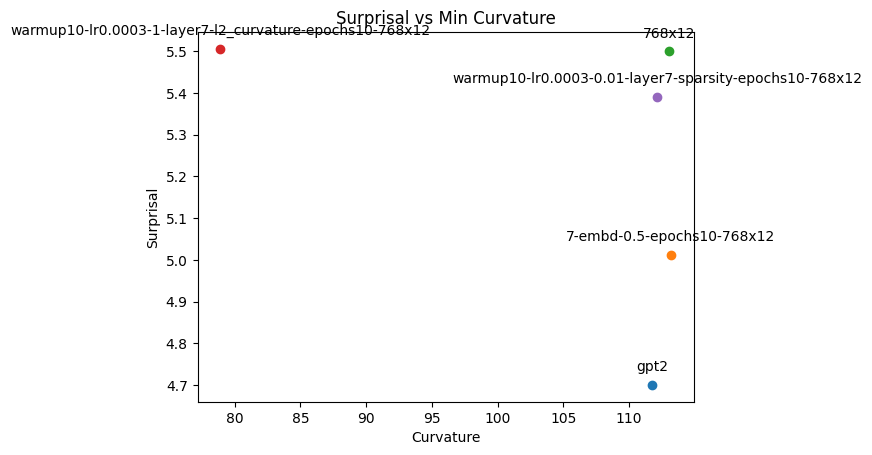

In [37]:
curvature_dict = torch.load(f"{dir_path}/curvature_dict.pt", map_location=torch.device('cpu'))
surprisal_dict = torch.load(f"{dir_path}/surprisal_dict.pt", map_location=torch.device('cpu'))
reg_surprisals = surprisal_dict["none"]["5000sentences.new"]

# plt.figure(figsize=(10, 10))
fulltrained_models = ["warmup10-lr0.0003-1-layer9-l2_curvature-768x12", "warmup10-lr0.0003-1-l2_curvature-768x12", "warmup5-lr0.0006-1-l2_curvature-768x12", '768x12', "warmup10-lr0.0006-1-layer9-l2_curvature-epochs20-768x12", "warmup5-lr0.0006-1-layer8-l2_curvature-epochs10-768x12",  "warmup20-lr0.0006-1-layer8-l2_curvature-epochs20-768x12", "warmup10-lr0.0006-1-layer8-l2_curvature-epochs10-768x12", "epochs20-768x12", "warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12", "warmup10-lr0.0006-1-layer8-l1_curvature-epochs10-768x12", "warmup10-lr0.0006-1-layer9-l2_curvature-epochs10-768x12", "warmup10-lr0.0006-0.1-layer8-l2_curvature-epochs10-768x12", "warmup10-lr0.0006--0.1-layer8-l2_curvature-epochs10-768x12", "warmup10-lr0.0006-1-layer8-l0_curvature-epochs10-768x12"]

for i, model_name in enumerate(model_names):
    curvature = curvature_dict[model_name]["min_curve"]
    surprisal = np.nanmean(reg_surprisals[model_name])
    plt.scatter(curvature, surprisal, label=model_name)
    plt.annotate(model_name, (curvature, surprisal), textcoords="offset points", xytext=(0,10), ha='center')

plt.title("Surprisal vs Min Curvature")
plt.xlabel("Curvature")
plt.ylabel("Surprisal")
# plt.legend()
plt.show()



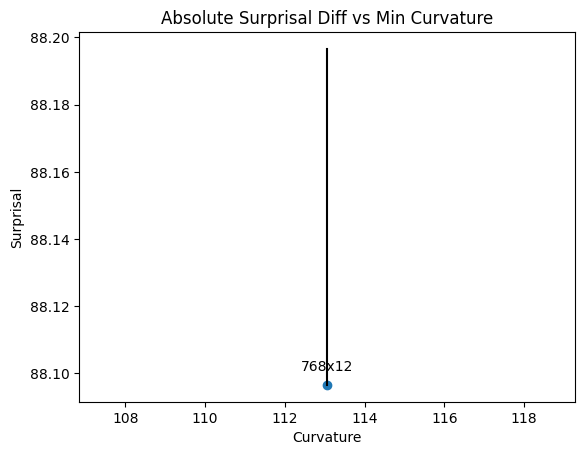

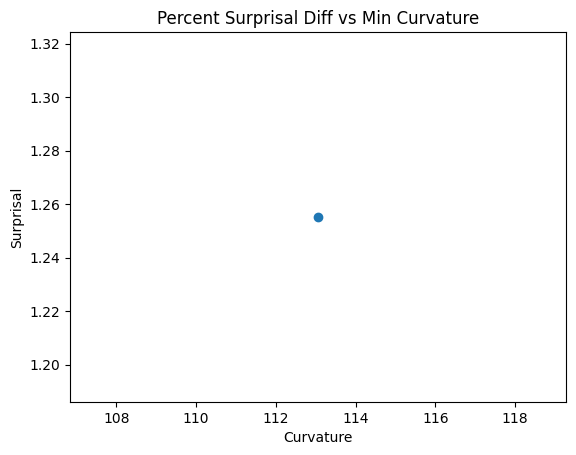

In [33]:
# curvature_dict = torch.load(f"{dir_path}/curvature_dict.pt", map_location=torch.device('cpu'))
# surprisal_dict = torch.load(f"{dir_path}/surprisal_dict.pt", map_location=torch.device('cpu'))

size = 2
location = "post_block"
layer = 7
perturbation_type = f"activation_random_size{size}_layer{layer}_{location}"

perturbed_surprisals = surprisal_dict[perturbation_type]["5000sentences.new"]
reg_surprisals = surprisal_dict["none"]["5000sentences.new"]

# plt.figure(figsize=(10, 10))
    
for i, model_name in enumerate(model_names):
    if f"layer{layer}" in model_name:
        continue
    curvature = curvature_dict[model_name]["min_curve"]
    reg_surprisal = np.nanmean(reg_surprisals[model_name])
    perturbed_surprisal = np.nanmean(perturbed_surprisals[model_name])
    plt.scatter(curvature, perturbed_surprisal - reg_surprisal)
    #label the point with a pointer only if model_name is 768x12. Put a line from the point to the text  
    if model_name == "768x12" or model_name == "gpt2" or model_name == "warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12":
        plt.annotate(model_name, (curvature, perturbed_surprisal - reg_surprisal), textcoords="offset points", xytext=(0,10), ha='center')
        plt.plot([curvature, curvature], [perturbed_surprisal - reg_surprisal, perturbed_surprisal - reg_surprisal + 0.1], 'k-')


plt.title("Absolute Surprisal Diff vs Min Curvature")
plt.xlabel("Curvature")
plt.ylabel("Surprisal")
# plt.legend()
plt.show()


for i, model_name in enumerate(model_names):
    if f"layer{layer}" in model_name:
        continue
    curvature = curvature_dict[model_name]["min_curve"]
    reg_surprisal = np.nanmean(reg_surprisals[model_name])
    perturbed_surprisal = np.nanmean(perturbed_surprisals[model_name])
    plt.scatter(curvature, (perturbed_surprisal - reg_surprisal) / reg_surprisal, label=model_name)
    # if model_name == "768x12" or model_name == "warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12":
    #     plt.annotate(model_name, (curvature, (perturbed_surprisal - reg_surprisal) / reg_surprisal), textcoords="offset points", xytext=(0,10), ha='center')
    #     plt.plot([curvature, curvature], [(perturbed_surprisal - reg_surprisal) / reg_surprisal, (perturbed_surprisal - reg_surprisal) / reg_surprisal + 0.1], 'k-')


plt.title("Percent Surprisal Diff vs Min Curvature")
plt.xlabel("Curvature")
plt.ylabel("Surprisal")
# plt.legend()
plt.show()


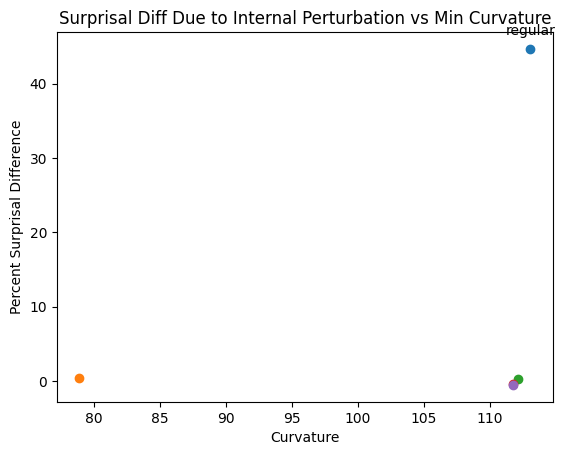

In [34]:
# curvature_dict = torch.load(f"{dir_path}/curvature_dict.pt", map_location=torch.device('cpu'))
# surprisal_dict = torch.load(f"{dir_path}/surprisal_dict.pt", map_location=torch.device('cpu'))

size = 2
location = "post_block"
    
for i, model_name in enumerate(model_names):

    difference_mean = []

    for layer in [3, 7]:
        if f"layer{layer}" in model_name:
            continue
        perturbation_type = f"activation_random_size{size}_layer{layer}_{location}"
        perturbed_surprisals = surprisal_dict[perturbation_type]["5000sentences.new"]
        reg_surprisals = surprisal_dict["none"]["5000sentences.new"]

        curvature = curvature_dict[model_name]["min_curve"]
        reg_surprisal = np.nanmean(reg_surprisals[model_name])
        perturbed_surprisal = np.nanmean(perturbed_surprisals[model_name])

        difference_mean.append(perturbed_surprisal - reg_surprisal)
        difference_mean.append((perturbed_surprisal - reg_surprisal) / reg_surprisal)
    
    difference_mean = np.mean(difference_mean)

    plt.scatter(curvature, difference_mean, label=model_name)

    # #label the point with a pointer only if model_name is 768x12. Put a line from the point to the text  
    # if model_name in refined_full_models:
    #     plt.annotate(refined_full_models[model_name], (curvature, difference_mean), textcoords="offset points", xytext=(0,10), ha='center')
    #     plt.plot([curvature, curvature], [difference_mean, difference_mean+ 0.1], 'k-')

    if model_name == "warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12":
        plt.annotate("layer8", (curvature, difference_mean), textcoords="offset points", xytext=(0,10), ha='center')
        # plt.plot([curvature, curvature], [difference_mean, difference_mean+ 0.1], 'k-')
    if model_name == "768x12":
        plt.annotate("regular", (curvature, difference_mean), textcoords="offset points", xytext=(0,10), ha='center')
        # plt.plot([curvature, curvature], [difference_mean, difference_mean+ 0.1], 'k-')

plt.title("Surprisal Diff Due to Internal Perturbation vs Min Curvature")
plt.xlabel("Curvature")
plt.ylabel("Percent Surprisal Difference")
# plt.legend()
plt.show()




In [36]:
curvature_dict = torch.load(f"{dir_path}/curvature_dict.pt", map_location=torch.device('cpu'))
surprisal_dict = torch.load(f"{dir_path}/surprisal_dict.pt", map_location=torch.device('cpu'))
    
for i, model_name in enumerate(good_fulltrained_models):

    difference_mean = []

    for perturbation_type in ["remove", "swap", "replace"]:
        perturbed_surprisals = surprisal_dict[perturbation_type]["continuation"]
        reg_surprisals = surprisal_dict["none"]["continuation"]

        curvature = curvature_dict[model_name]["min_curve"]
        reg_surprisal = np.nanmean(reg_surprisals[model_name])
        perturbed_surprisal = np.nanmean(perturbed_surprisals[model_name])

        difference_mean.append(perturbed_surprisal - reg_surprisal)
        difference_mean.append((perturbed_surprisal - reg_surprisal) / reg_surprisal)
    
    difference_mean = np.mean(difference_mean)
    
    plt.scatter(curvature, difference_mean, label=model_name)

    if model_name == "warmup10-lr0.0003-1-layer8-l2_curvature-epochs10-768x12":
        plt.annotate("layer8", (curvature, difference_mean), textcoords="offset points", xytext=(0,10), ha='center')
        # plt.plot([curvature, curvature], [difference_mean, difference_mean+ 0.1], 'k-')
    if model_name == "768x12":
        plt.annotate("regular", (curvature, difference_mean), textcoords="offset points", xytext=(0,10), ha='center')
        # plt.plot([curvature, curvature], [difference_mean, difference_mean+ 0. 1], 'k-')


plt.title("Surprisal Diff Due to Input Perturbation (Continuation) vs Min Curvature")
plt.xlabel("Curvature")
plt.ylabel("Percent Surprisal Difference")
# plt.legend()
plt.show()




NameError: name 'good_fulltrained_models' is not defined

### Visualizing How Internal Perturbations Affect Surprisal

/tmp/ipykernel_992925/1245746403.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


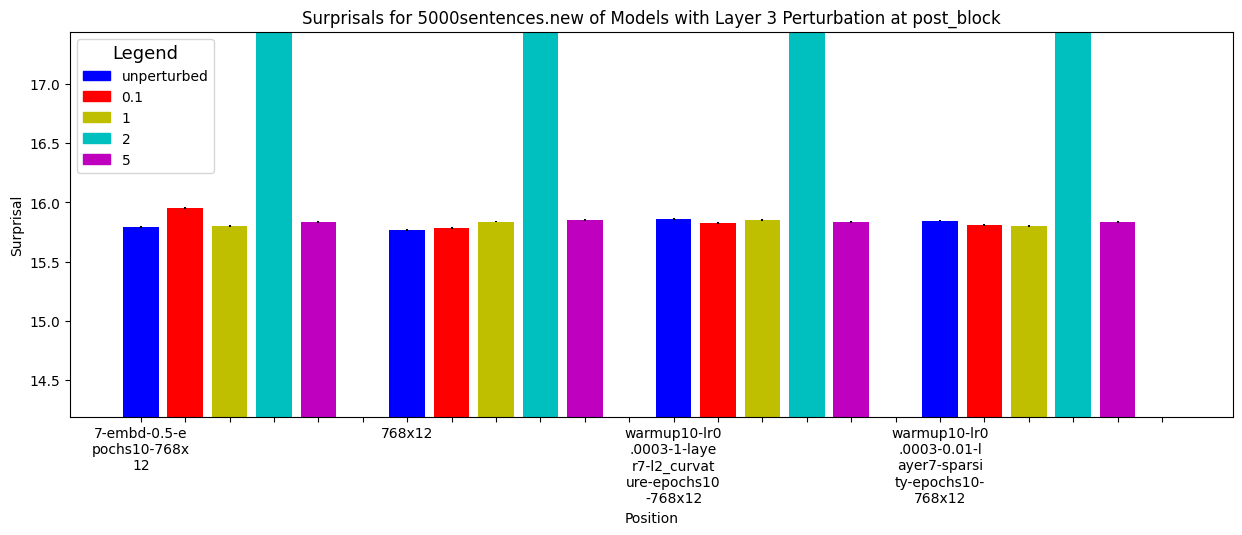

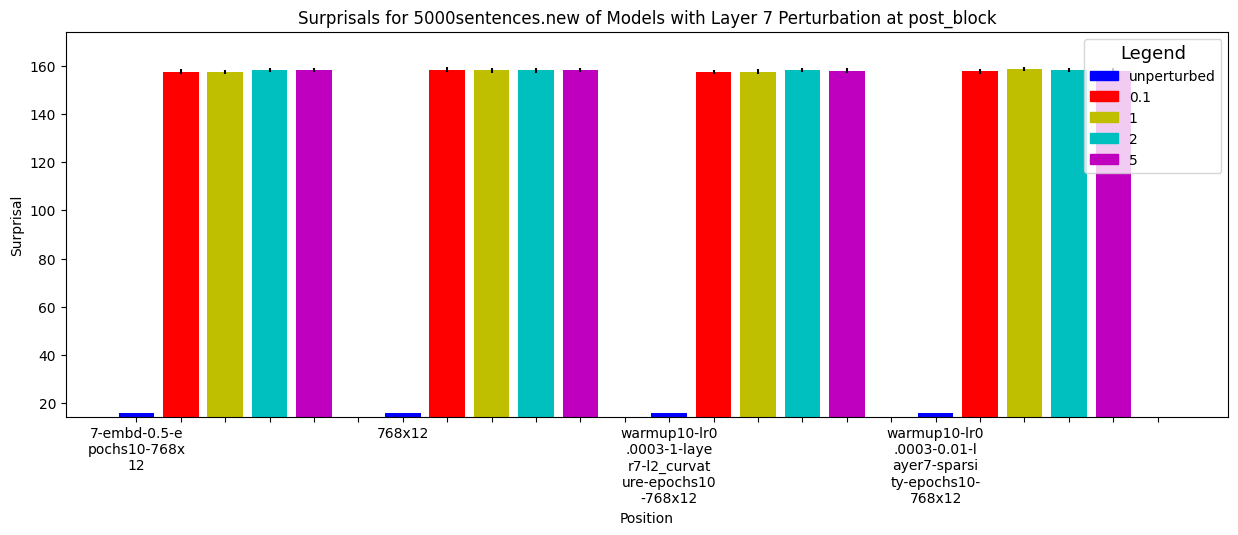

In [34]:
surprisal_type = "5000sentences.new"

model_names_dict = {model_name:model_name for model_name in model_names}

for location in ["post_block"]:
    for layer in [3, 7]:
        visualize_all_sizes_surprisal_differences(model_names_dict, surprisal_type, location, layer)

/tmp/ipykernel_1446607/591902307.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


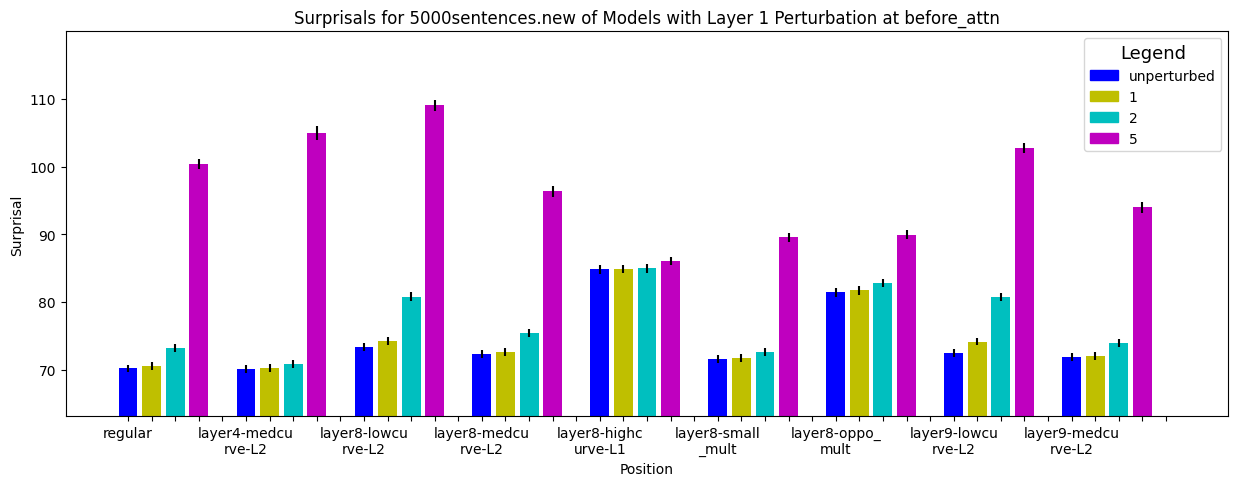

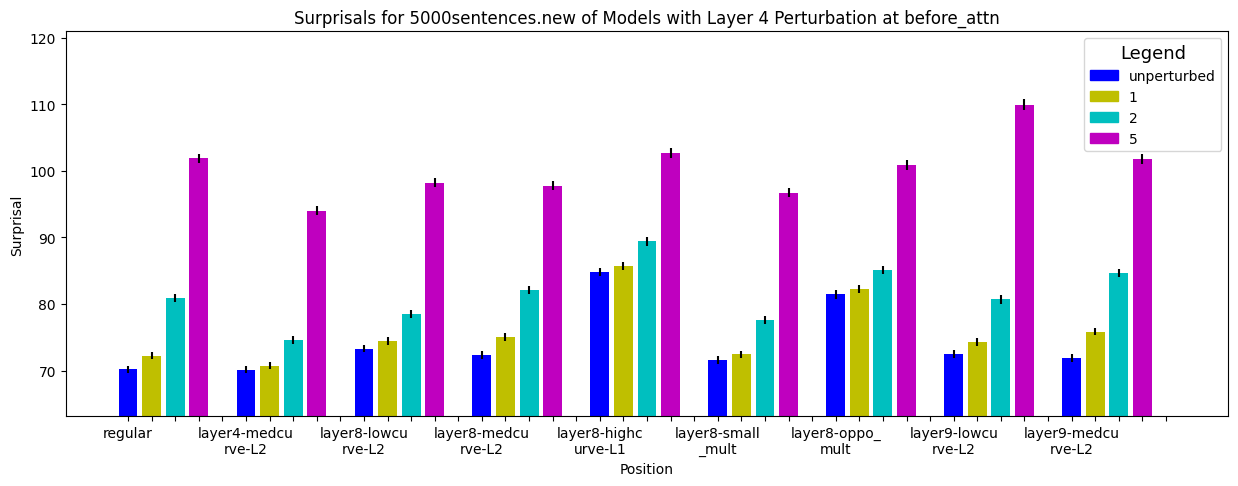

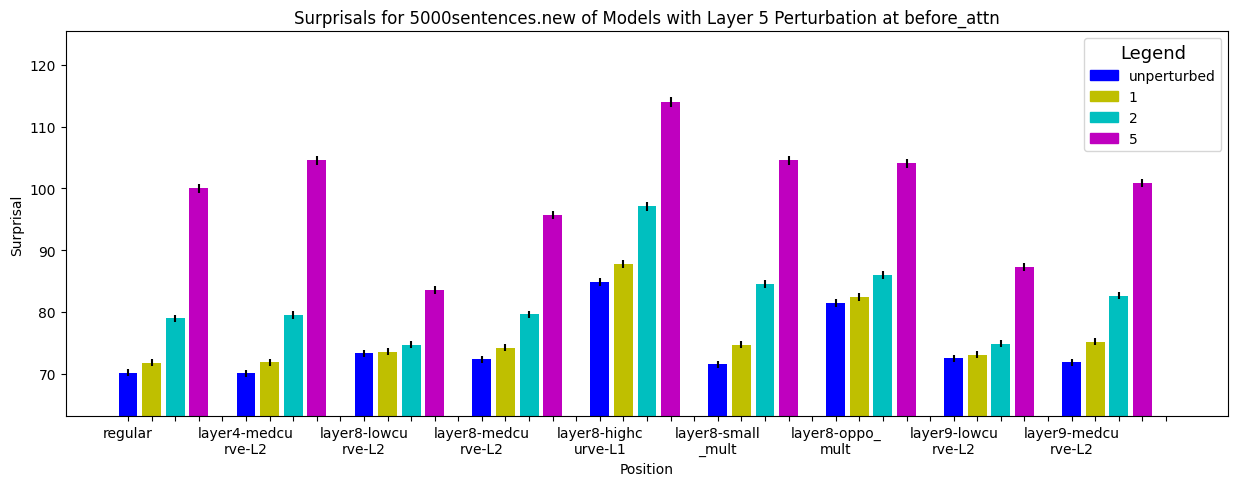

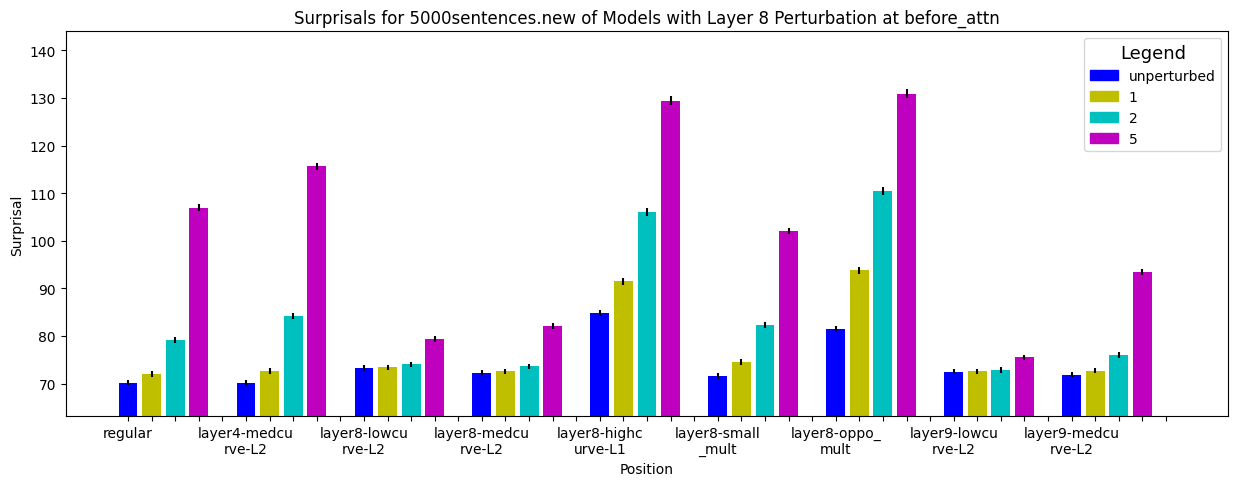

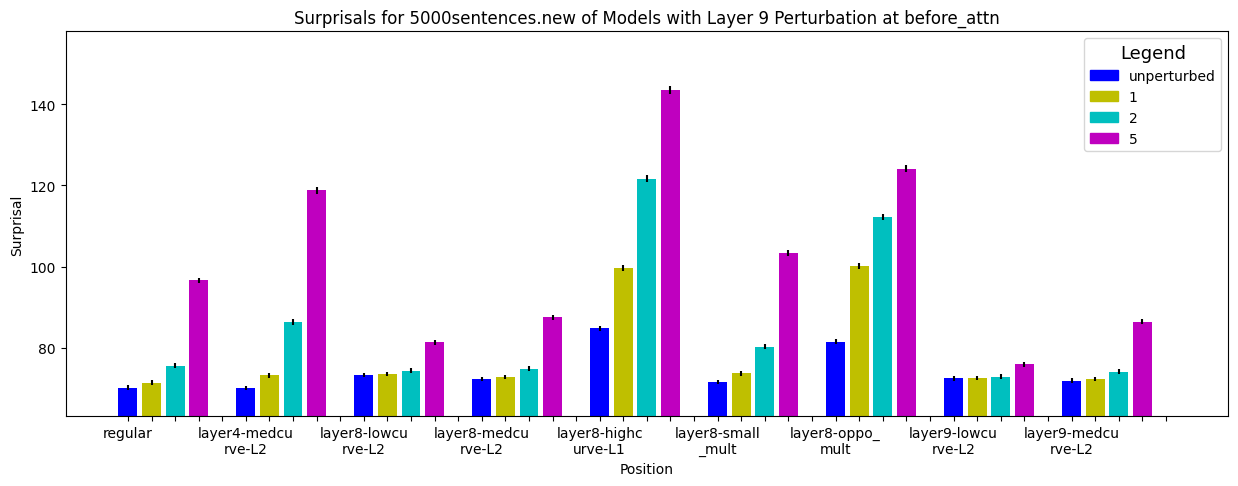

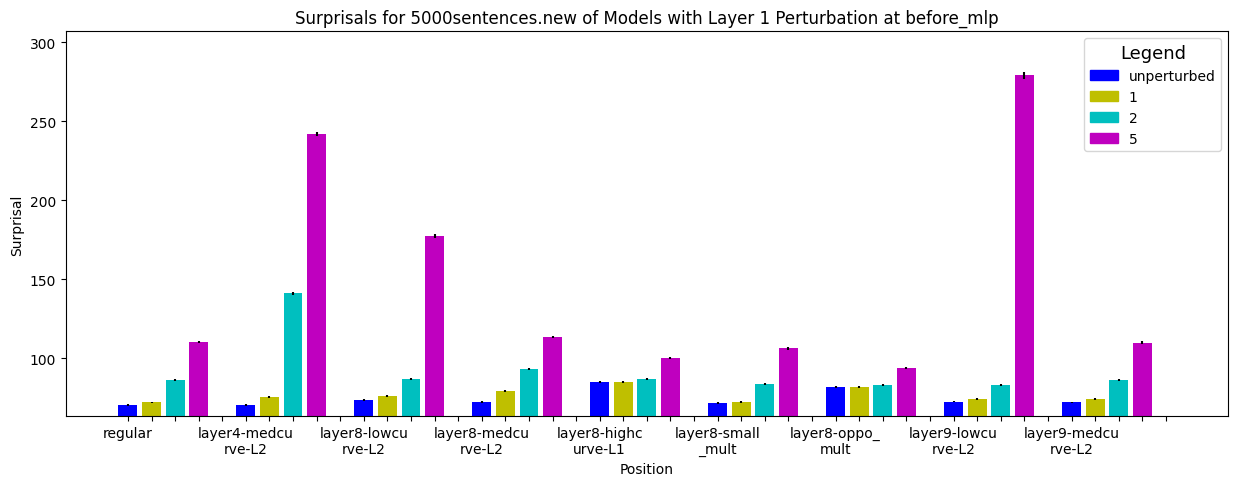

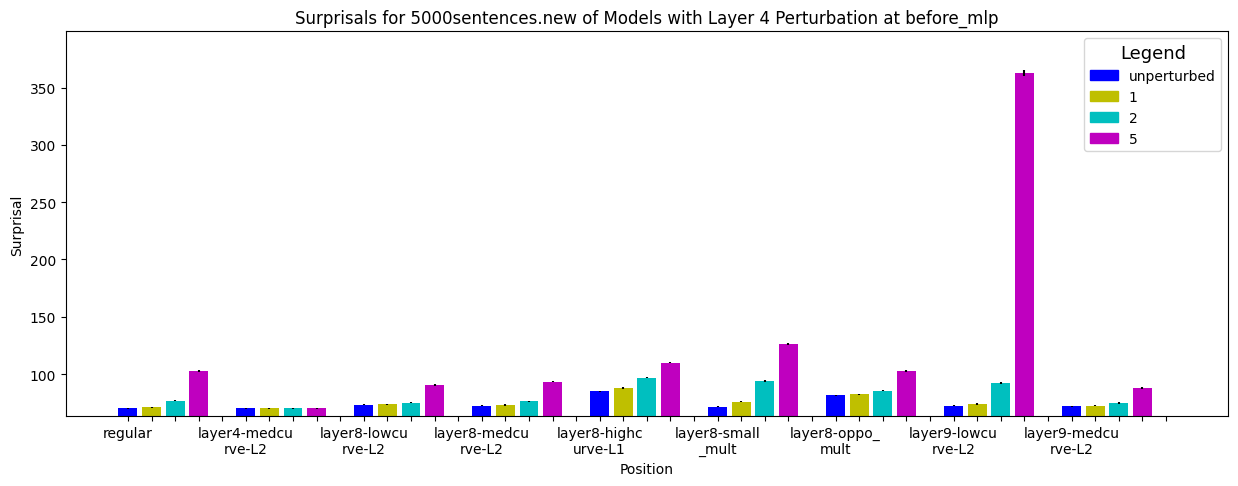

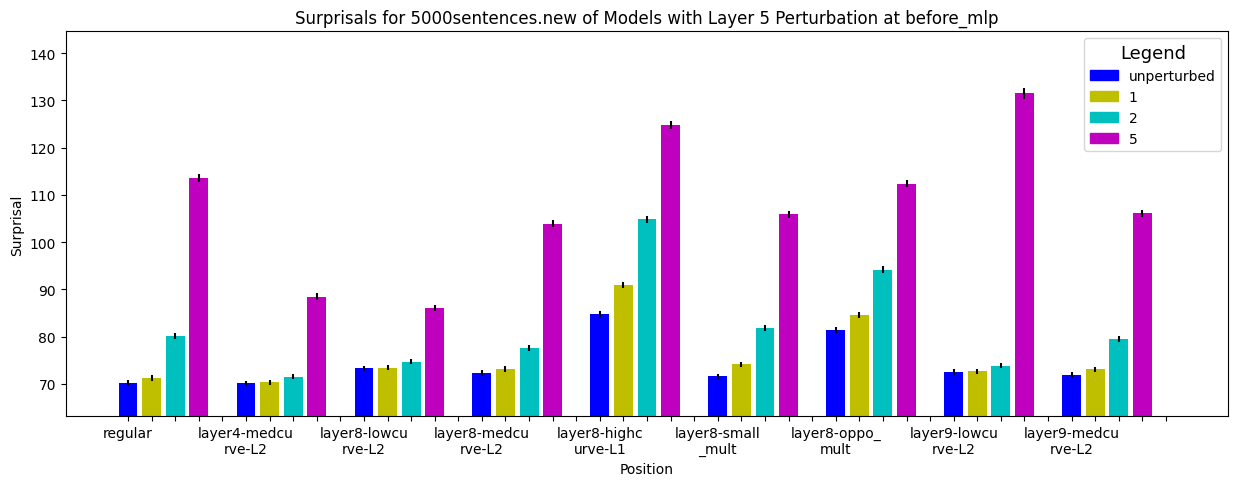

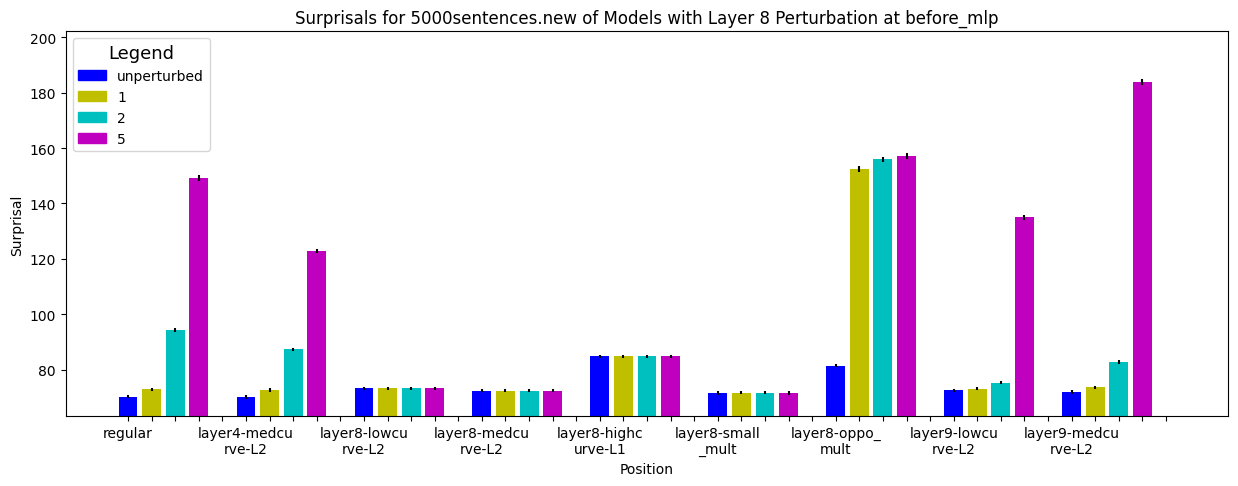

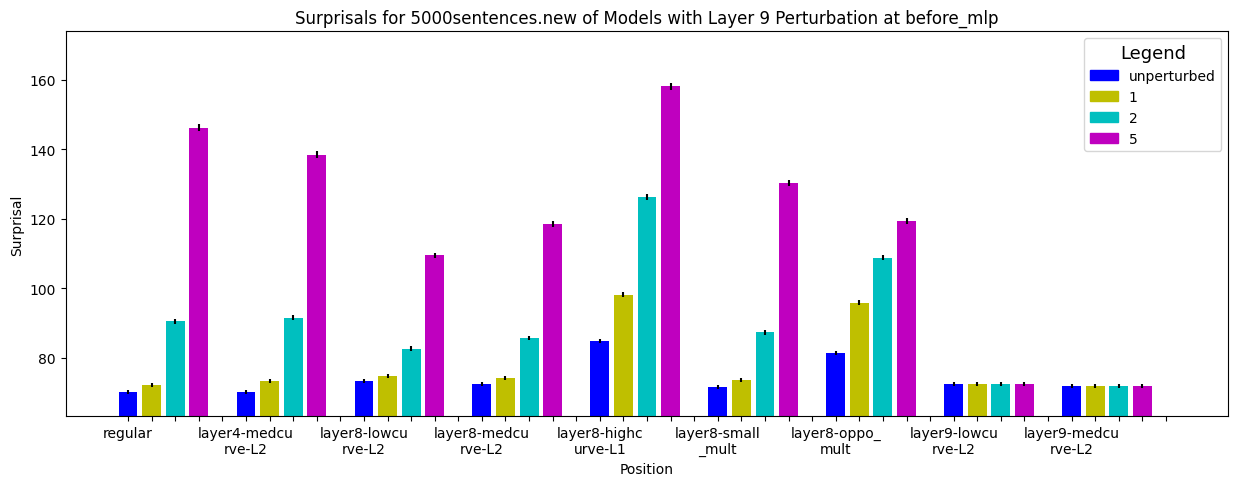

In [ ]:
surprisal_type = "5000sentences.new"

for location in ["before_attn", "before_mlp"]:
    for layer in [1, 4, 5, 8, 9]:
        visualize_all_sizes_surprisal_differences(refined_full_models, surprisal_type, location, layer)

In [ ]:
surprisal_type = "5000sentences.new"
visualize_surprisals(fulltrained_models, "none", surprisal_type)

for size in [0.1, 0.5, 1, 2, 5]:
    for location in ["before_attn", "before_mlp"]:
        peturbation_type = f"activation_random_size{size}_layer4_{location}"
        # visualize_surprisals(fine_tuned_models, peturbation_type, surprisal_type)
        # try:
        visualize_surprisal_percent_differences(refined_models, peturbation_type, surprisal_type)
        # except:
        #     print(f"failed for {peturbation_type}")
        # visualize_surprisal_differences(fulltrained_models, peturbation_type, surprisal_type)

/tmp/ipykernel_13163/591902307.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


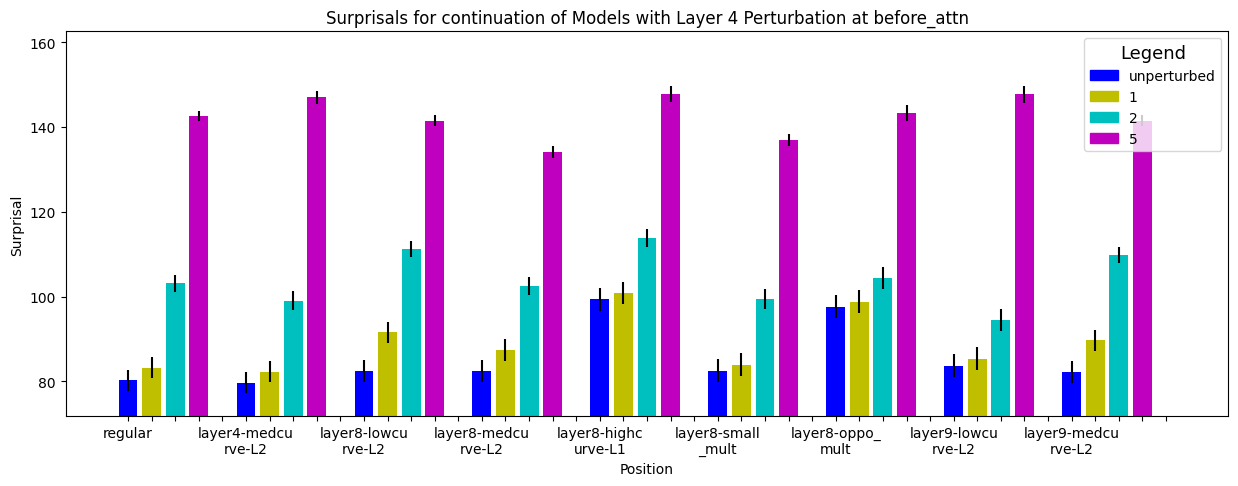

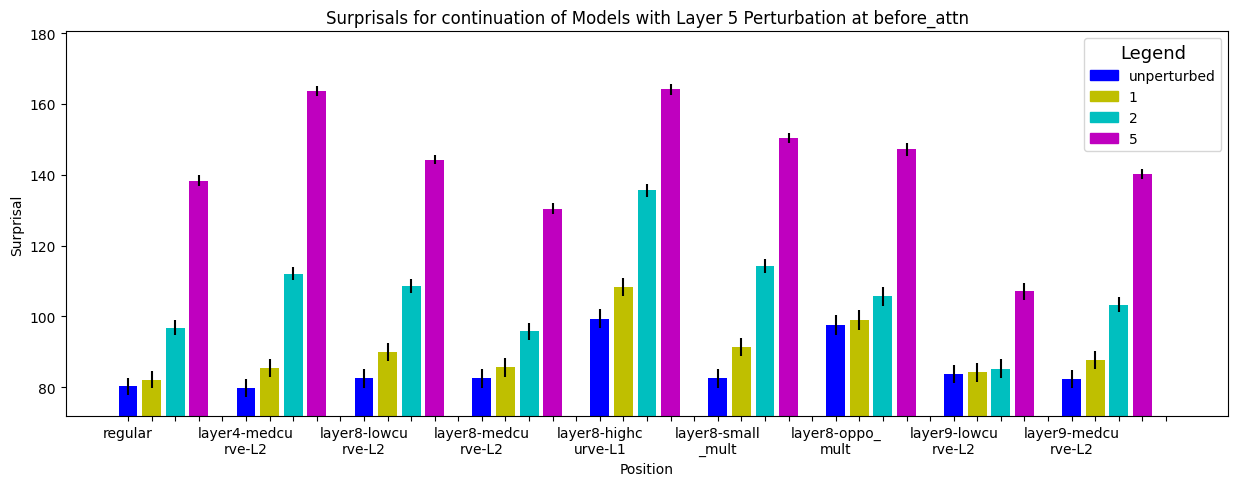

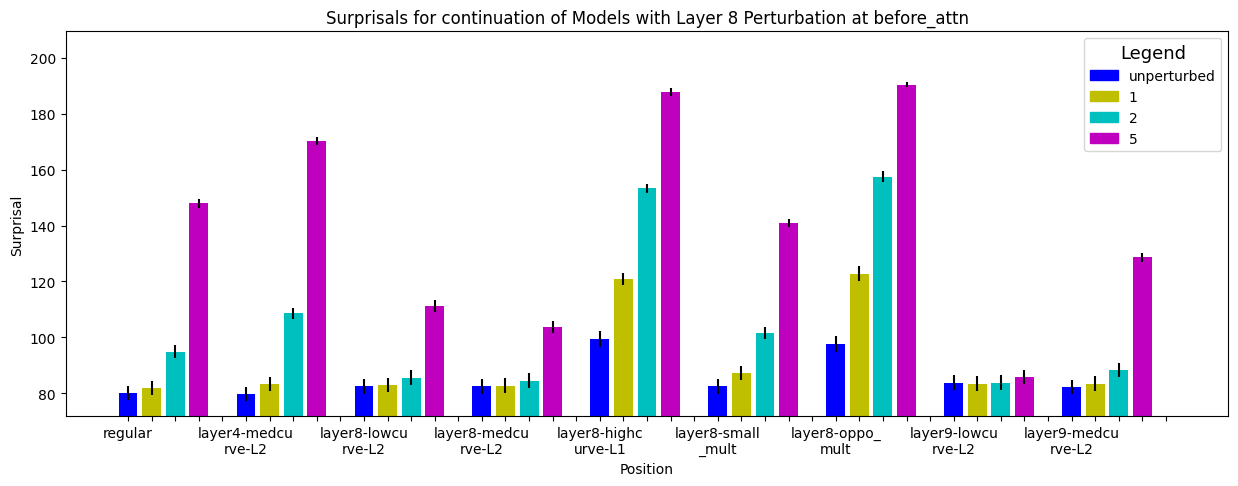

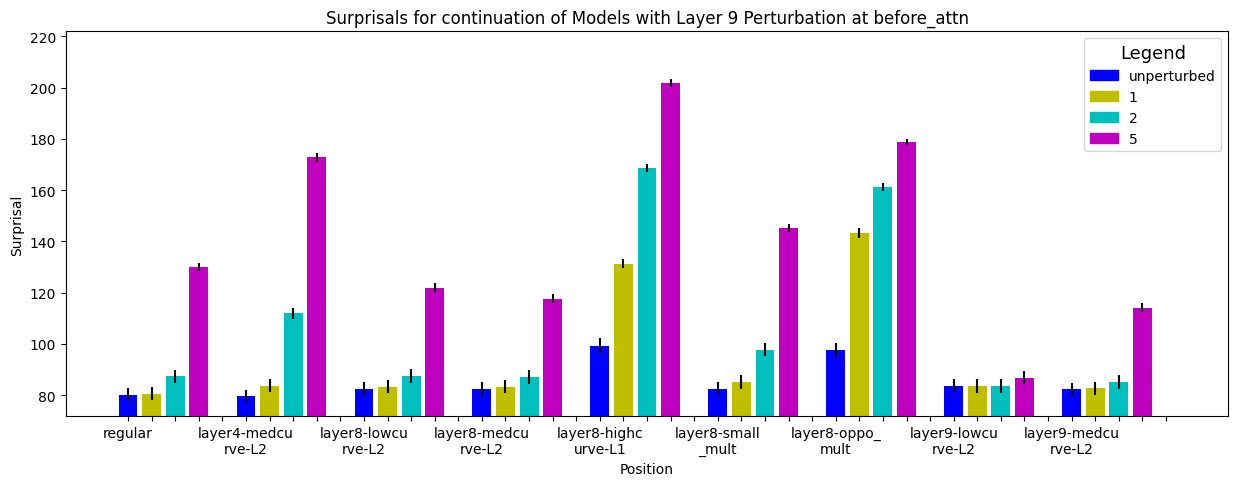

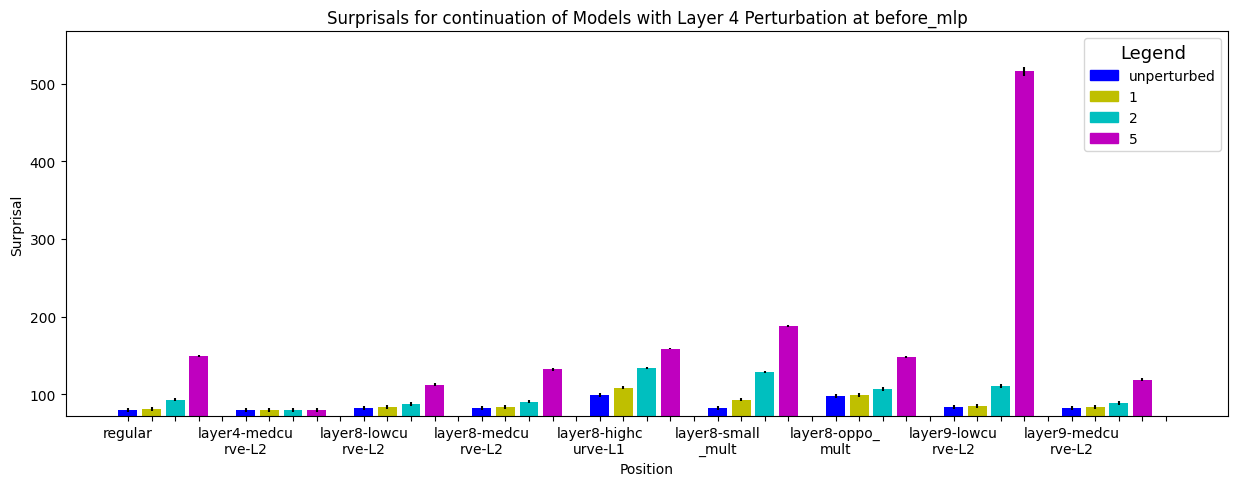

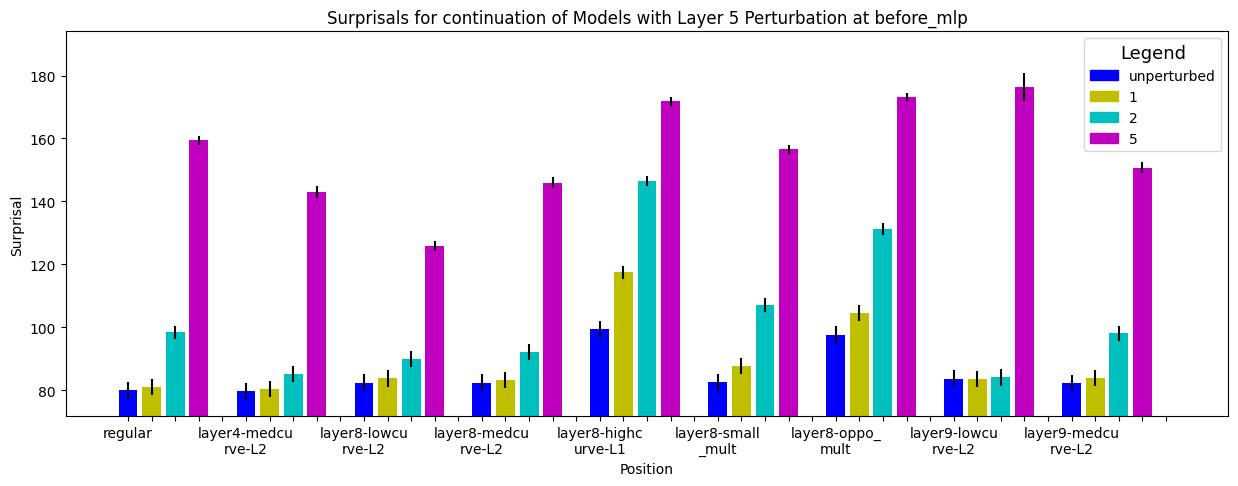

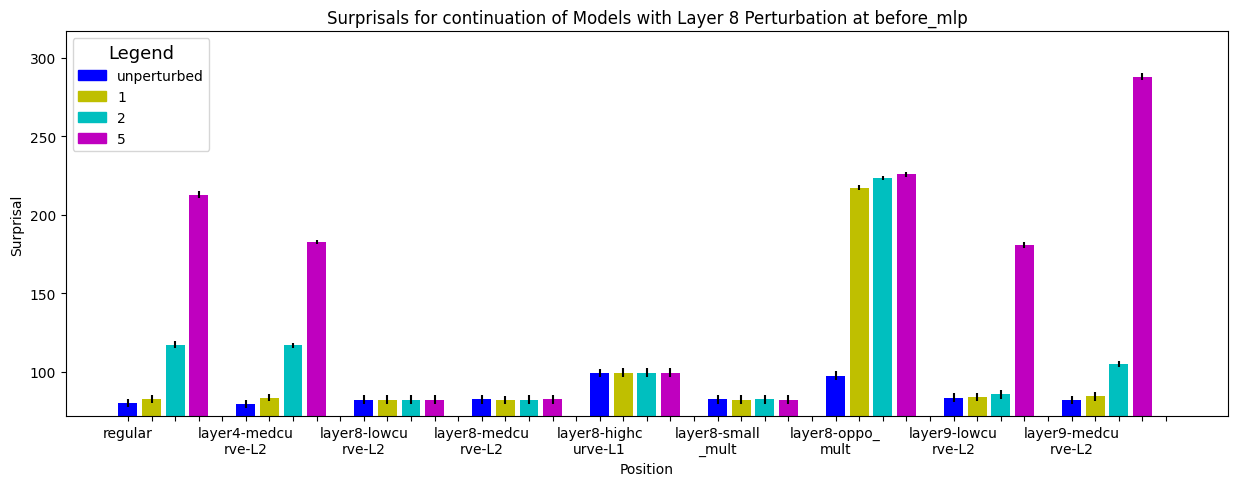

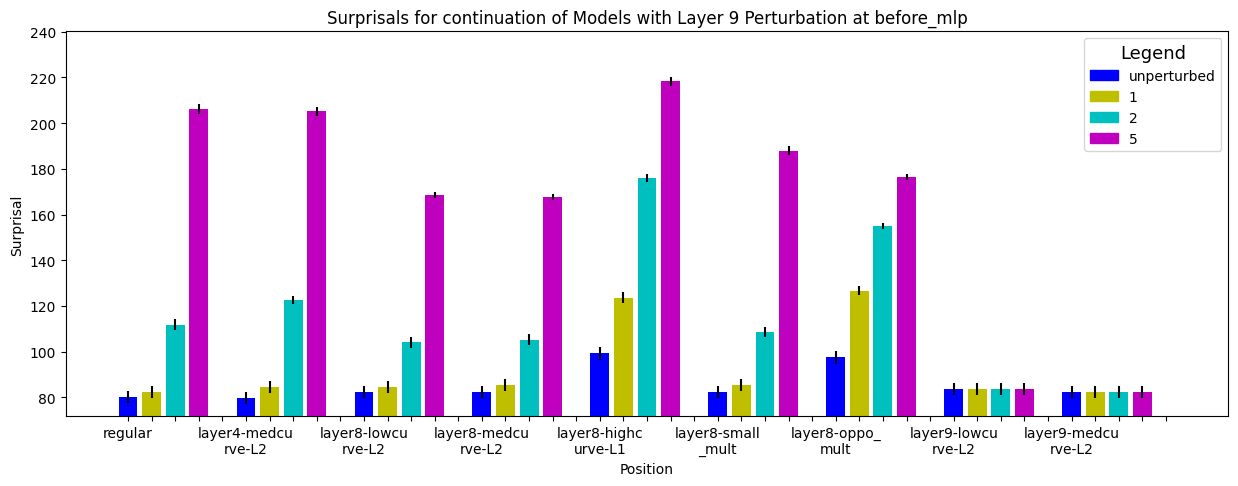

In [ ]:
surprisal_type = "continuation"

for location in ["before_attn", "before_mlp"]:
    for layer in [4, 5, 8, 9]:
        visualize_all_sizes_surprisal_differences(refined_full_models, surprisal_type, location, layer)

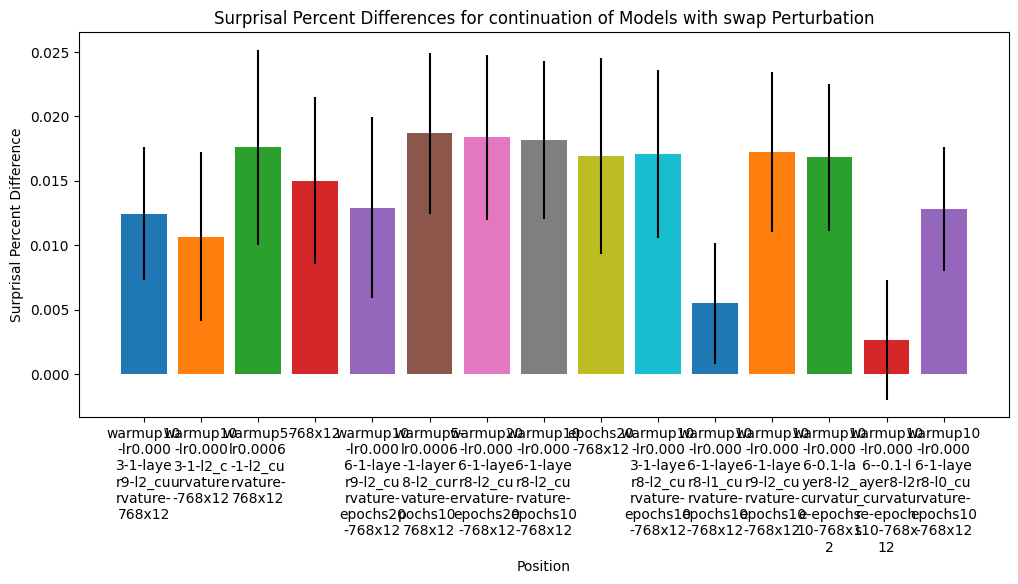

/tmp/ipykernel_1514358/3283589601.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


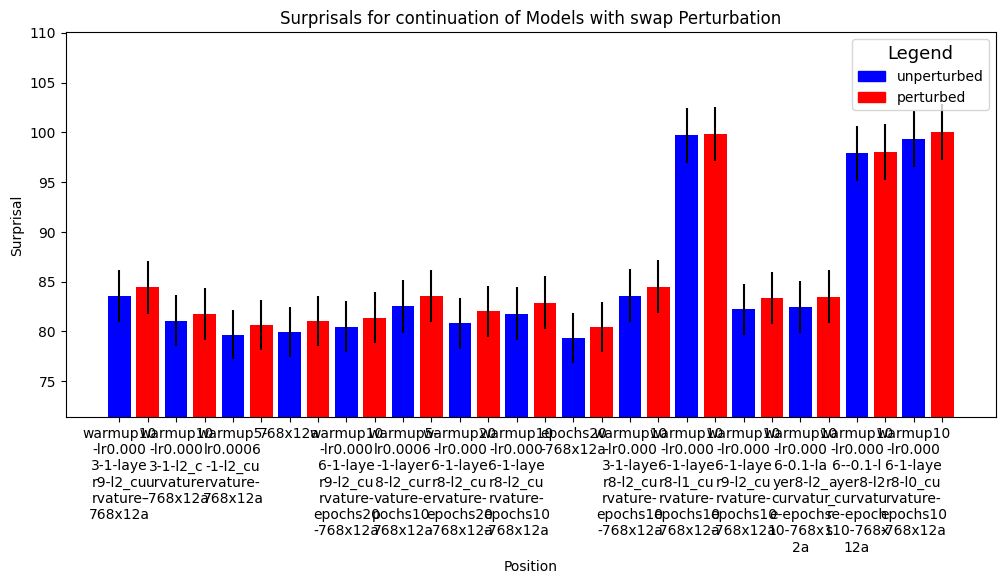

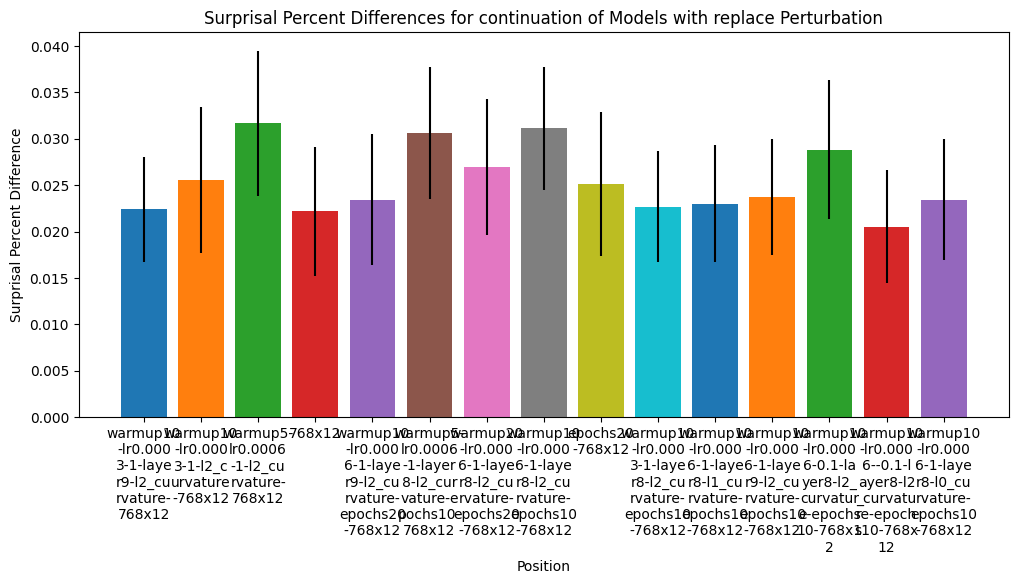

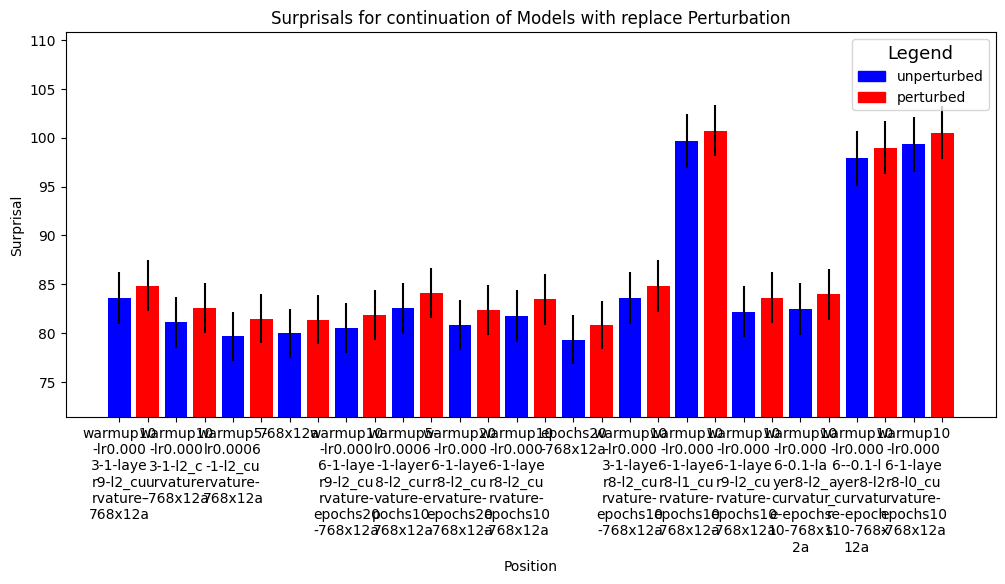

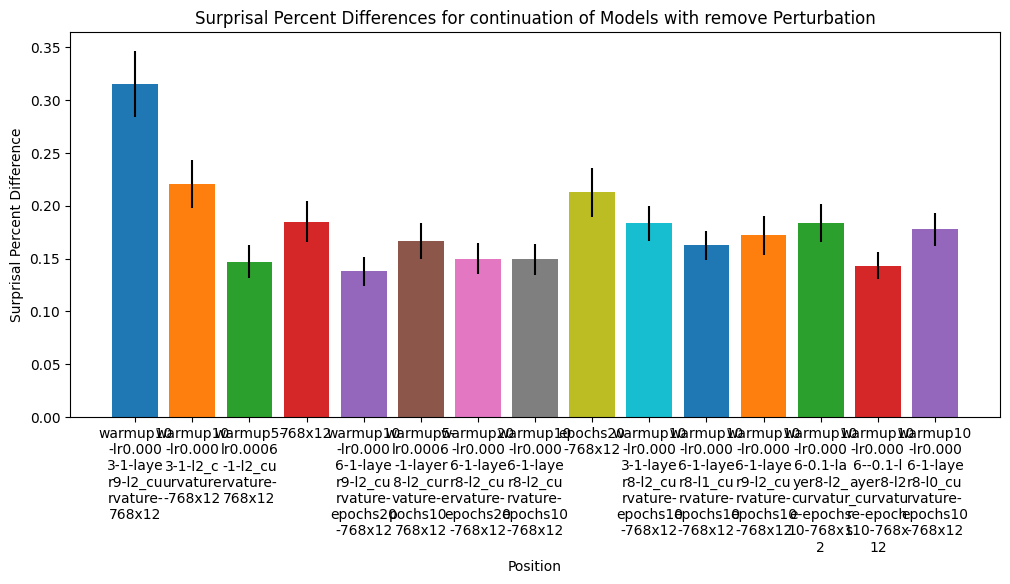

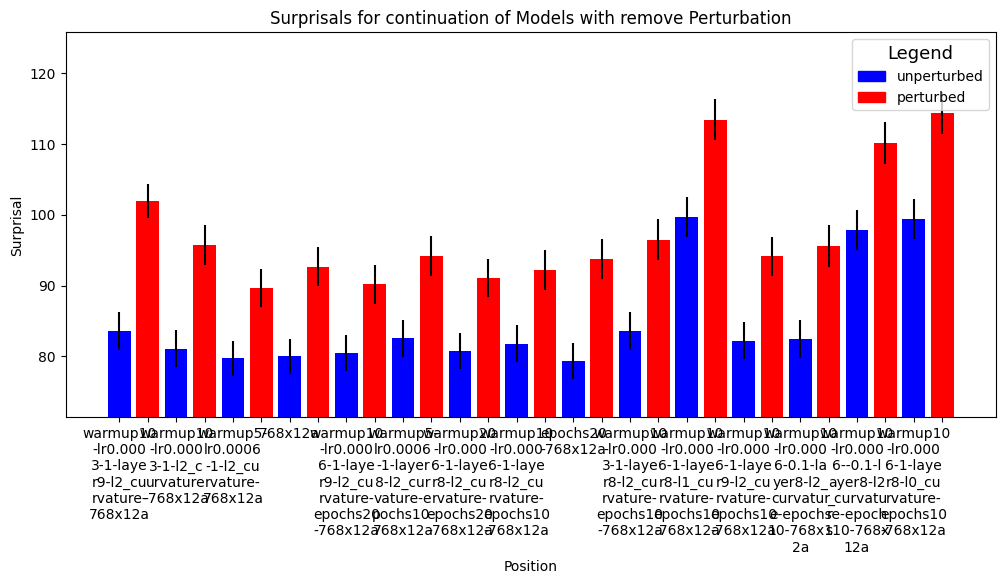

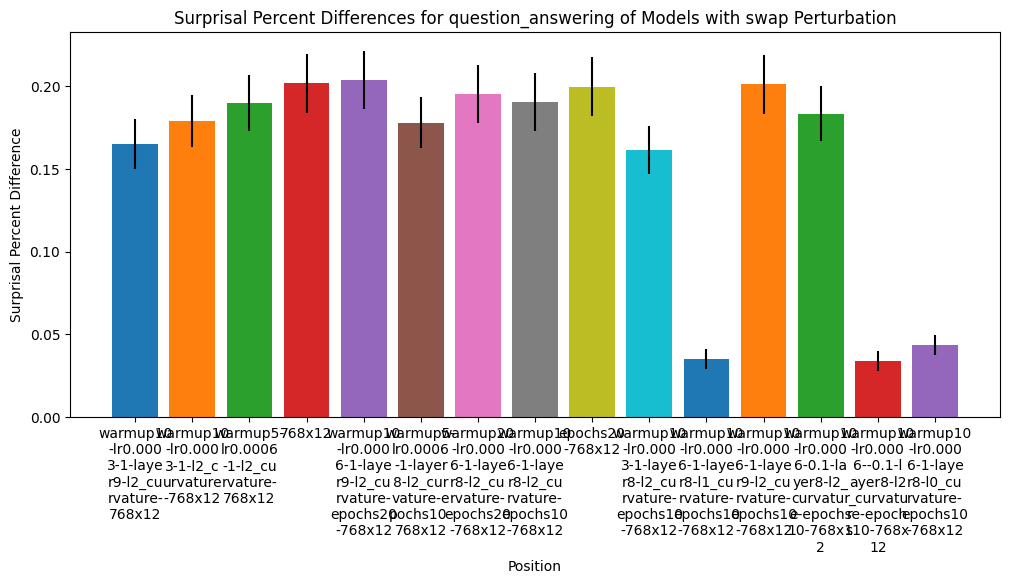

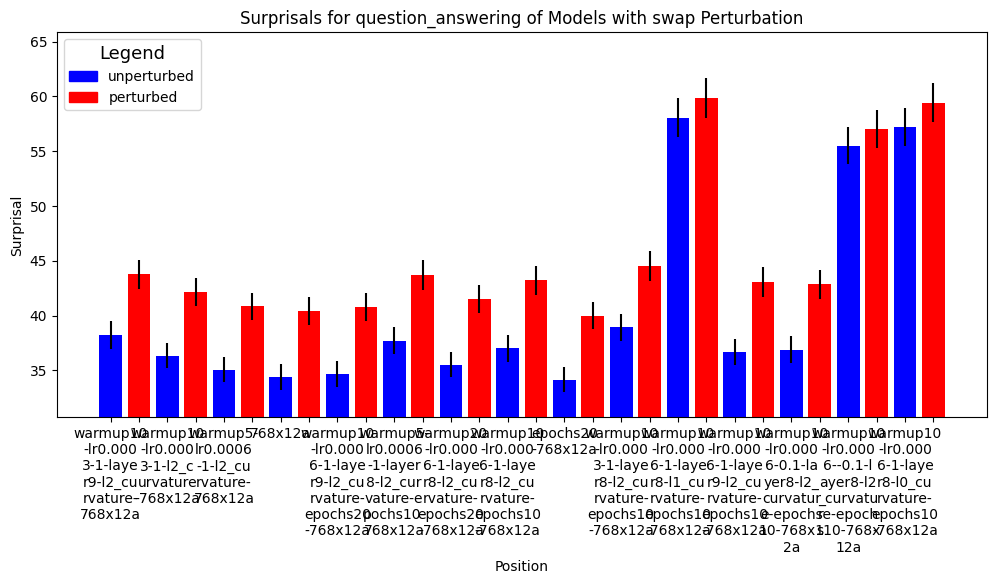

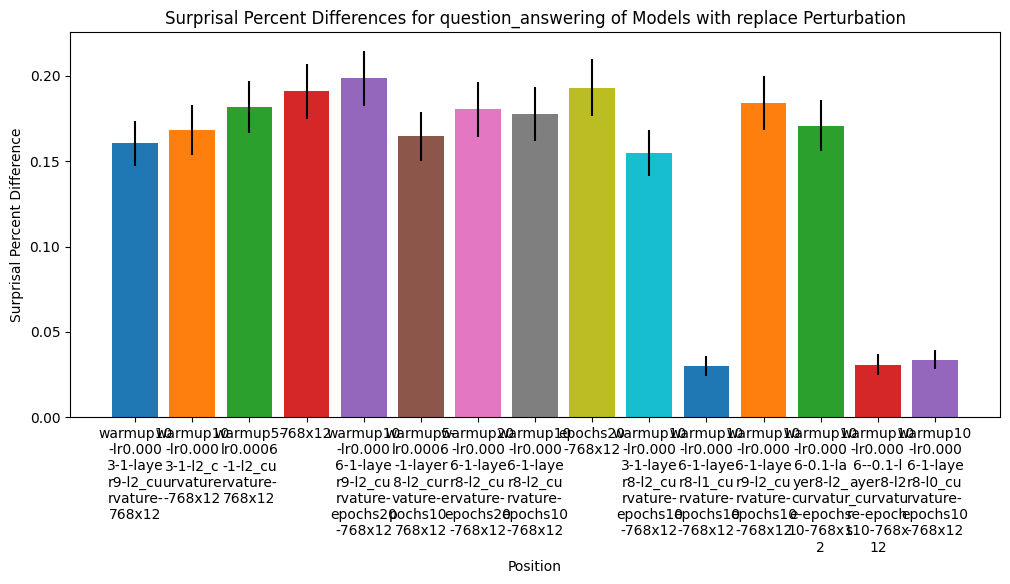

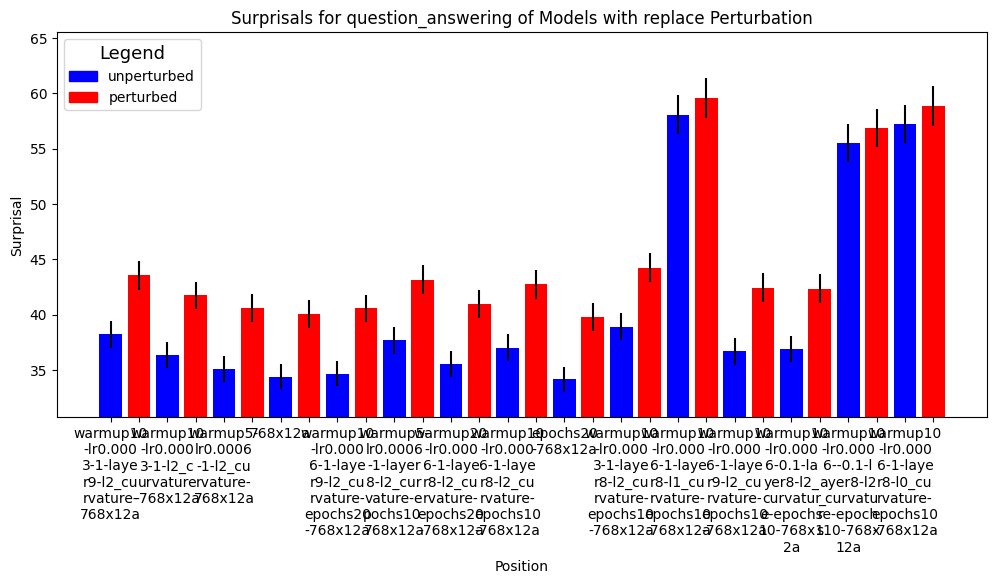

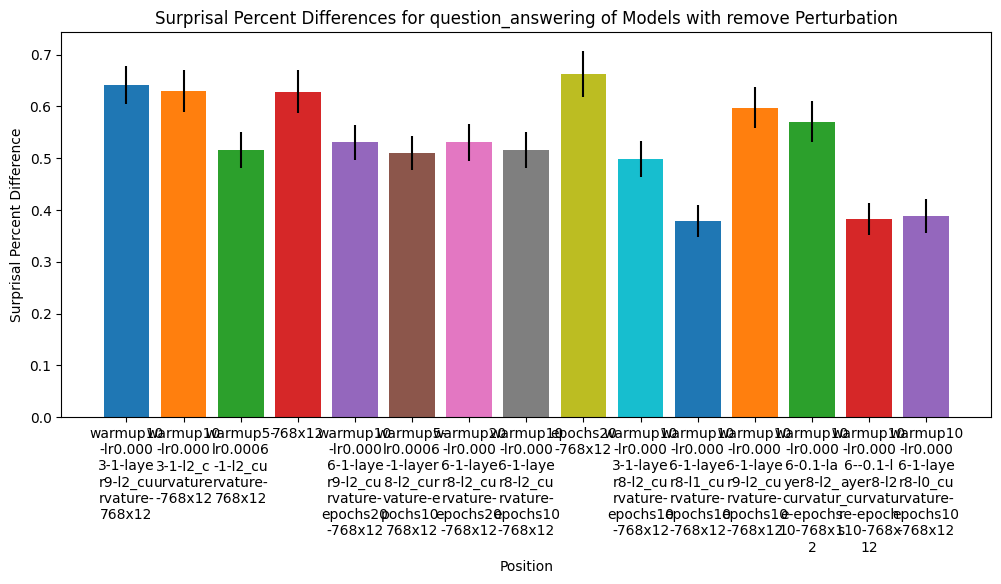

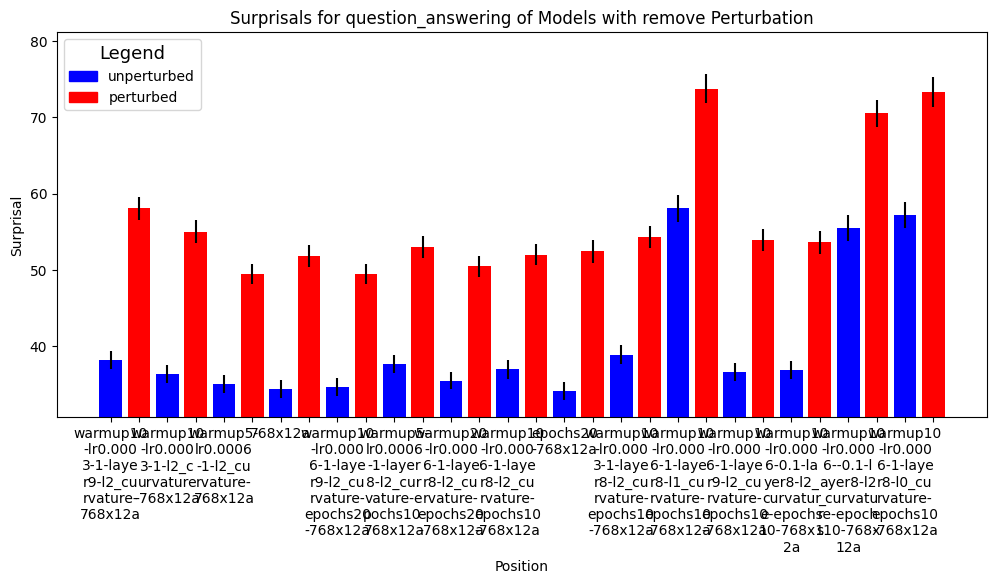

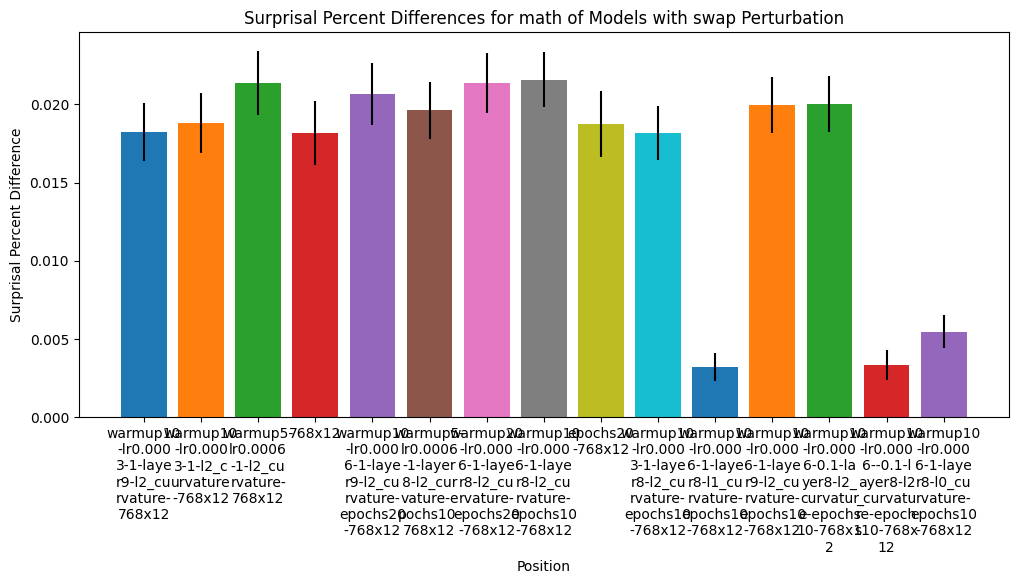

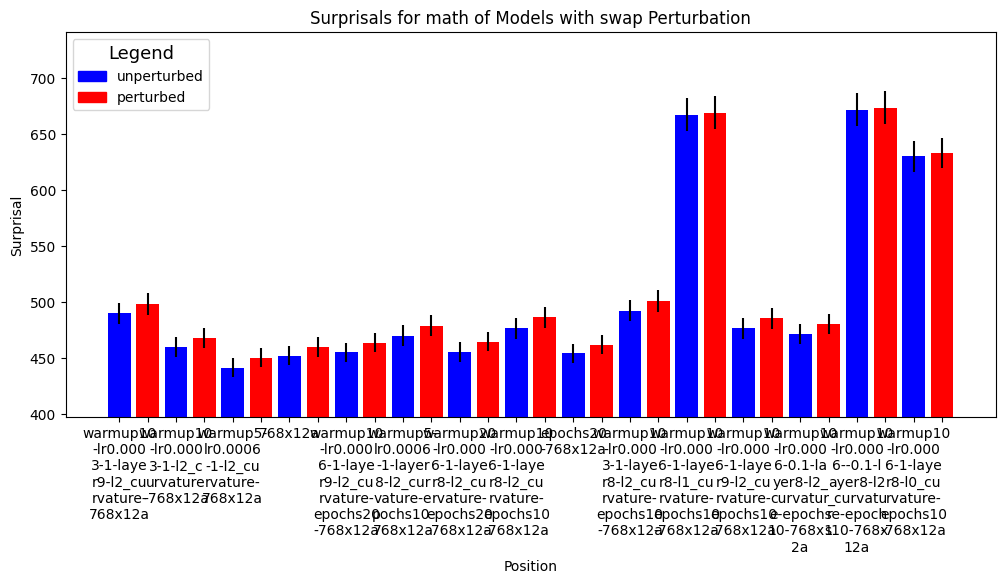

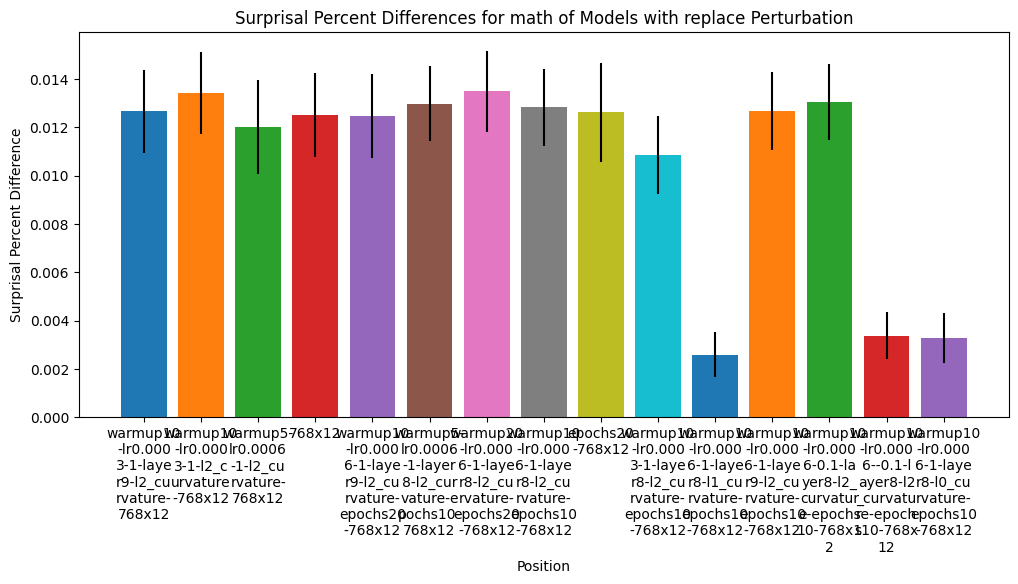

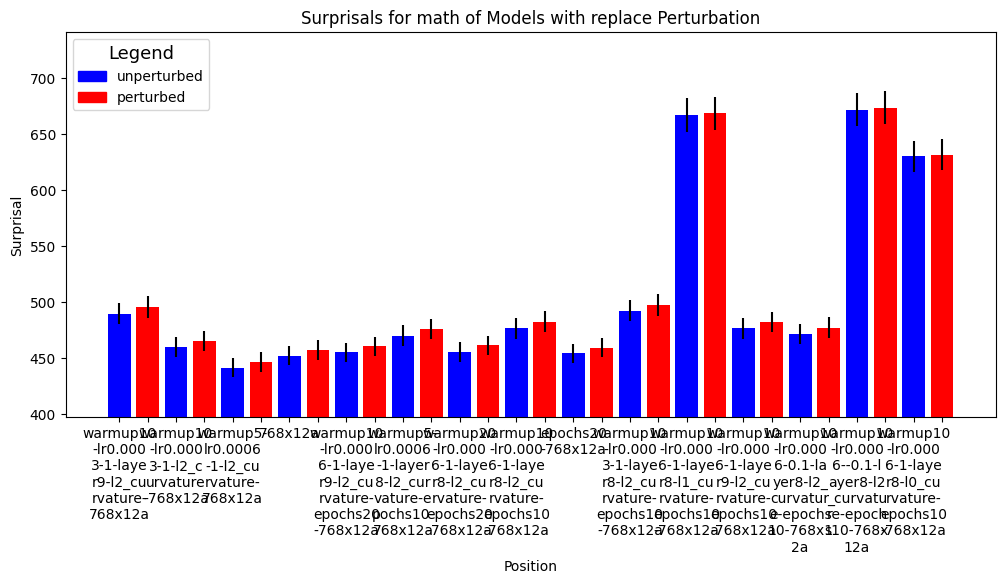

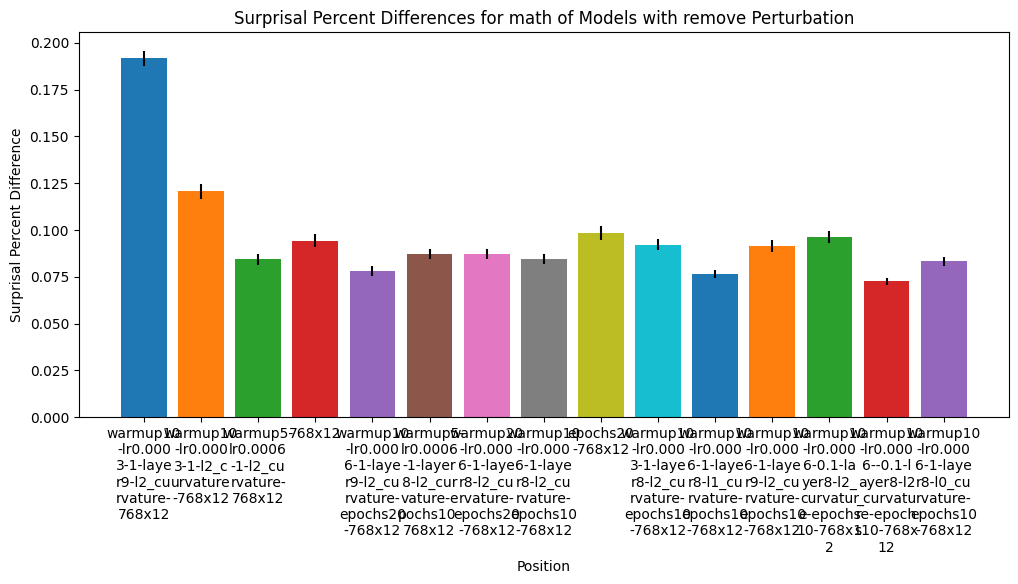

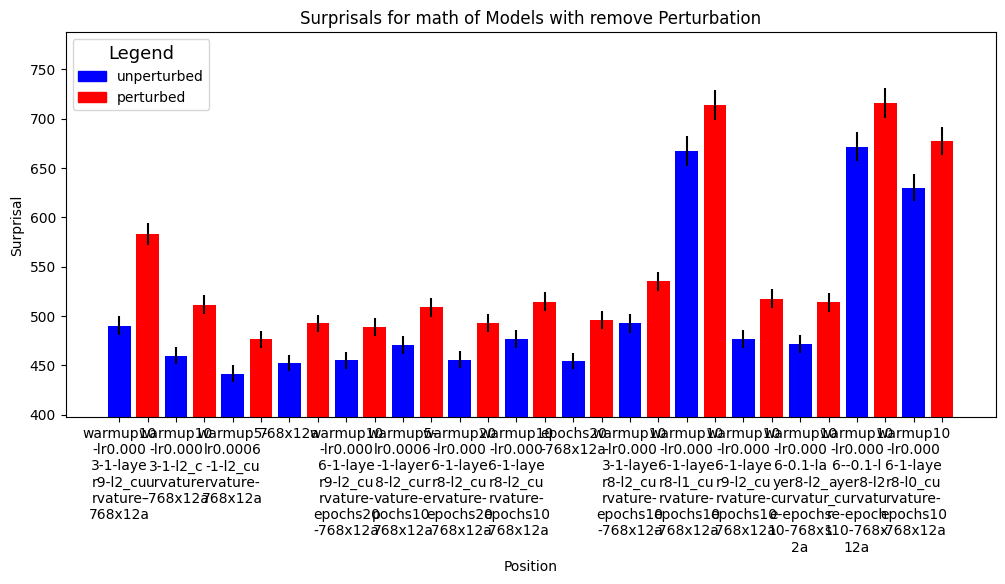

In [ ]:
# refined_full_m
for surprisal_type in ["continuation", "question_answering", "math"]:
    for perturbation_type in ["swap", "replace", "remove"]:
        visualize_surprisal_percent_differences(fulltrained_models, perturbation_type, surprisal_type)
        visualize_surprisal_differences_both_sides(fulltrained_models, perturbation_type, surprisal_type)

In [ ]:
relational_noun_agreement_scores = json.load(open(f"{path}/relational_noun_agreement_scores.json"))
for model_name in model_names:
    print(model_name, relational_noun_agreement_scores[model_name])

finetuned-1-l2_curvature-768x12 0.86
finetuned-1-l1_curvature-768x12 0.869
huggingface-pretrained-768x12 0.868
finetuned-1-l0_curvature-768x12 0.89
warmup5-lr0.0006-0.1-l0_curvature-768x12 0.806
multi-warmup5-lr0.0006-1-l2_curvature-768x12 0.792
warmup5-lr0.0006-1-l2_curvature-768x12 0.878
768x12_test 0.839
